# Multimodal Transport Optimization

In [ ]:
## IMPORTS
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional, Set, NamedTuple
import numpy as np
from enum import Enum


In [ ]:
## INITIAL SETTING

@dataclass(frozen=True)
class Point:
    """Представляє точку на карті (склад або точку доставки)."""
    id: int
    x: float
    y: float

@dataclass(frozen=True)
class Order:
    """Представляє замовлення для доставки."""
    id: int
    delivery_point: Point
    volume: float  # об'єм замовлення

@dataclass(frozen=True)
class Warehouse(Point):
    """Представляє склад."""
    capacity: float  # максимальна місткість складу

@dataclass
class Truck:
    """Представляє вантажівку."""
    id: int
    capacity: float  # вантажопідйомність
    current_load: float = 0.0  # поточне завантаження



In [ ]:

class LogisticsProblem:
    """Клас, що представляє всю логістичну задачу."""

    def __init__(self,
                 warehouses: List[Warehouse],
                 orders: List[Order],
                 trucks: List[Truck]):
        self.warehouses = warehouses
        self.orders = orders
        self.trucks = trucks
        self._distance_matrix = None

    def distance(self, point1: Point, point2: Point) -> float:
        """Обчислює евклідову відстань між двома точками."""
        return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

    def compute_distance_matrix(self) -> np.ndarray:
        """Обчислює матрицю відстаней між всіма точками."""
        if self._distance_matrix is None:
            # Створюємо список всіх точок (склади + точки доставки)
            all_points = self.warehouses + [order.delivery_point for order in self.orders]
            n = len(all_points)

            # Ініціалізуємо матрицю відстаней
            self._distance_matrix = np.zeros((n, n))

            # Заповнюємо матрицю відстаней
            for i in range(n):
                for j in range(i+1, n):
                    dist = self.distance(all_points[i], all_points[j])
                    self._distance_matrix[i,j] = dist
                    self._distance_matrix[j,i] = dist

        return self._distance_matrix



In [ ]:


def generate_test_problem(
    num_warehouses: int = 3,
    num_orders: int = 20,
    num_trucks: int = 5,
    area_size: float = 100.0,
    seed: int = 42
) -> LogisticsProblem:
    """
    Генерує тестовий екземпляр логістичної задачі.

    Args:
        num_warehouses: кількість складів
        num_orders: кількість замовлень
        num_trucks: кількість вантажівок
        area_size: розмір області (квадрат area_size x area_size)
        seed: seed для генератора випадкових чисел

    Returns:
        LogisticsProblem: згенерований екземпляр задачі
    """
    np.random.seed(seed)

    # Генеруємо склади
    warehouses = [
        Warehouse(
            id=i,
            x=np.random.uniform(0, area_size),
            y=np.random.uniform(0, area_size),
            capacity=np.random.uniform(1000, 2000)  # випадкова місткість складу
        )
        for i in range(num_warehouses)
    ]

    # Генеруємо точки доставки та замовлення
    orders = [
        Order(
            id=i,
            delivery_point=Point(
                id=i+num_warehouses,
                x=np.random.uniform(0, area_size),
                y=np.random.uniform(0, area_size)
            ),
            volume=np.random.uniform(10, 100)  # випадковий об'єм замовлення
        )
        for i in range(num_orders)
    ]

    # Генеруємо вантажівки з різною вантажопідйомністю
    trucks = [
        Truck(
            id=i,
            capacity=np.random.uniform(300, 500)  # випадкова вантажопідйомність
        )
        for i in range(num_trucks)
    ]

    return LogisticsProblem(warehouses, orders, trucks)


In [ ]:


# Створюємо тестову задачу
problem = generate_test_problem()

# Обчислюємо матрицю відстаней
distances = problem.compute_distance_matrix()

print(f"Створено задачу з {len(problem.warehouses)} складами,",
        f"{len(problem.orders)} замовленнями та {len(problem.trucks)} вантажівками")
print(f"\nРозмір матриці відстаней: {distances.shape}")


Створено задачу з 3 складами, 20 замовленнями та 5 вантажівками

Розмір матриці відстаней: (23, 23)


## INIT SOLUTION

In [ ]:
@dataclass
class Route:
    """Представляє маршрут для однієї вантажівки."""
    truck: Truck
    warehouse: Warehouse
    orders: List[Order] = field(default_factory=list)
    total_distance: float = 0.0

    def add_order(self, order: Order) -> bool:
        """Додає замовлення до маршруту, якщо це можливо."""
        if self.truck.current_load + order.volume <= self.truck.capacity:
            self.orders.append(order)
            self.truck.current_load += order.volume
            return True
        return False

    def __str__(self):
        return f"Route(truck={self.truck.id}, orders={[o.id for o in self.orders]}, " \
               f"load={self.truck.current_load:.1f}/{self.truck.capacity:.1f})"


In [ ]:

class Solution:
    """Представляє розв'язок логістичної задачі."""

    def __init__(self, problem: LogisticsProblem):
        self.problem = problem
        self.routes: List[Route] = []
        self.unassigned_orders: Set[Order] = set(problem.orders)

    def add_route(self, route: Route):
        """Додає новий маршрут до розв'язку."""
        self.routes.append(route)
        self.unassigned_orders -= set(route.orders)

    def compute_total_cost(self) -> float:
        """Обчислює загальну вартість (відстань) розв'язку."""
        total_cost = 0.0
        for route in self.routes:
            if not route.orders:
                continue

            # Відстань від складу до першої точки
            total_cost += self.problem.distance(route.warehouse, route.orders[0].delivery_point)

            # Відстані між послідовними точками маршруту
            for i in range(len(route.orders) - 1):
                total_cost += self.problem.distance(
                    route.orders[i].delivery_point,
                    route.orders[i + 1].delivery_point
                )

            # Відстань від останньої точки назад до складу
            total_cost += self.problem.distance(
                route.orders[-1].delivery_point,
                route.warehouse
            )

        return total_cost


In [ ]:

def greedy_solution(problem: LogisticsProblem) -> Solution:
    """
    Створює початковий розв'язок жадібним алгоритмом.

    Стратегія:
    1. Сортуємо замовлення за об'ємом (спочатку найбільші)
    2. Для кожного замовлення:
       - Знаходимо найближчий склад
       - Знаходимо вантажівку з достатньою вільною місткістю
       - Додаємо замовлення до маршруту цієї вантажівки
    """
    solution = Solution(problem)

    # Створюємо копію списку замовлень і сортуємо за об'ємом (спадання)
    sorted_orders = sorted(problem.orders, key=lambda x: x.volume, reverse=True)

    # Створюємо копію списку вантажівок
    available_trucks = problem.trucks.copy()

    for order in sorted_orders:
        # Знаходимо найближчий склад до точки доставки
        nearest_warehouse = min(
            problem.warehouses,
            key=lambda w: problem.distance(w, order.delivery_point)
        )

        # Шукаємо існуючий маршрут, який може взяти це замовлення
        route_found = False
        for route in solution.routes:
            if route.warehouse == nearest_warehouse and route.add_order(order):
                route_found = True
                solution.unassigned_orders.remove(order)
                break

        if not route_found and available_trucks:
            # Створюємо новий маршрут з новою вантажівкою
            truck = available_trucks.pop(0)
            new_route = Route(truck=truck, warehouse=nearest_warehouse)
            if new_route.add_order(order):
                solution.add_route(new_route)

    # Оптимізуємо кожен маршрут методом найближчого сусіда
    for route in solution.routes:
        if len(route.orders) > 1:
            route.orders = optimize_route_nearest_neighbor(
                route.warehouse, route.orders, problem
            )

    return solution



In [ ]:
def optimize_route_nearest_neighbor(
    warehouse: Warehouse,
    orders: List[Order],
    problem: LogisticsProblem
) -> List[Order]:
    """
    Оптимізує порядок відвідування точок в маршруті методом найближчого сусіда.
    """
    current_point = warehouse
    unvisited = orders.copy()
    optimized_route = []

    while unvisited:
        # Знаходимо найближчу невідвідану точку
        next_order = min(
            unvisited,
            key=lambda o: problem.distance(current_point, o.delivery_point)
        )
        optimized_route.append(next_order)
        unvisited.remove(next_order)
        current_point = next_order.delivery_point

    return optimized_route



In [ ]:



# Створюємо тестову задачу
problem = generate_test_problem(
    num_warehouses=2,
    num_orders=10,
    num_trucks=2,
    seed=333
)

# Знаходимо жадібний розв'язок
solution = greedy_solution(problem)

# Виводимо результати
print(f"\nЗнайдено розв'язок:")
print(f"Загальна вартість: {solution.compute_total_cost():.2f}")
print(f"Кількість маршрутів: {len(solution.routes)}")
print(f"Невиконані замовлення: {len(solution.unassigned_orders)}")

print("\nДеталі маршрутів:")
for i, route in enumerate(solution.routes, 1):
    print(f"{i}. {route}")



Знайдено розв'язок:
Загальна вартість: 361.49
Кількість маршрутів: 2
Невиконані замовлення: 0

Деталі маршрутів:
1. Route(truck=0, orders=[2, 8, 0, 6, 5, 9, 1, 7], load=282.5/300.7)
2. Route(truck=1, orders=[3, 4], load=127.4/413.9)


In [ ]:
## SOLUTION VISUALIZATION
import random
import matplotlib.pyplot as plt


In [ ]:
def generate_distinct_colors(n: int) -> List[Tuple[float, float, float]]:
    """Генерує n візуально різних кольорів."""
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7 + random.uniform(-0.2, 0.2)
        value = 0.7 + random.uniform(-0.2, 0.2)

        # Конвертуємо HSV в RGB
        h = hue * 6
        c = value * saturation
        x = c * (1 - abs(h % 2 - 1))
        m = value - c

        if h < 1:
            rgb = (c, x, 0)
        elif h < 2:
            rgb = (x, c, 0)
        elif h < 3:
            rgb = (0, c, x)
        elif h < 4:
            rgb = (0, x, c)
        elif h < 5:
            rgb = (x, 0, c)
        else:
            rgb = (c, 0, x)

        colors.append(tuple(v + m for v in rgb))

    return colors

In [ ]:

def visualize_solution(solution: Solution, title: str = "Логістичне рішення"):
    """Візуалізує розв'язок логістичної задачі."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Генеруємо кольори для маршрутів
    route_colors = generate_distinct_colors(len(solution.routes))

    # Перший графік: маршрути на карті
    # -------------------------------

    # Відображаємо склади
    warehouse_xs = [w.x for w in solution.problem.warehouses]
    warehouse_ys = [w.y for w in solution.problem.warehouses]
    ax1.scatter(warehouse_xs, warehouse_ys, c='red', s=100, marker='s',
               label='Склади')

    # Відображаємо точки доставки
    delivery_xs = [o.delivery_point.x for o in solution.problem.orders]
    delivery_ys = [o.delivery_point.y for o in solution.problem.orders]
    ax1.scatter(delivery_xs, delivery_ys, c='blue', s=50,
               label='Точки доставки')

    # Відображаємо маршрути
    for route, color in zip(solution.routes, route_colors):
        if not route.orders:
            continue

        # Малюємо лінію від складу до першої точки
        ax1.plot([route.warehouse.x, route.orders[0].delivery_point.x],
                [route.warehouse.y, route.orders[0].delivery_point.y],
                c=color, alpha=0.5)

        # Малюємо лінії між точками маршруту
        for i in range(len(route.orders) - 1):
            current = route.orders[i].delivery_point
            next_point = route.orders[i + 1].delivery_point
            ax1.plot([current.x, next_point.x],
                    [current.y, next_point.y],
                    c=color, alpha=0.5)

        # Малюємо лінію від останньої точки назад до складу
        ax1.plot([route.orders[-1].delivery_point.x, route.warehouse.x],
                [route.orders[-1].delivery_point.y, route.warehouse.y],
                c=color, alpha=0.5)

    ax1.set_title("Маршрути доставки")
    ax1.legend()
    ax1.grid(True)

    # Другий графік: завантаження вантажівок
    # -------------------------------

    truck_loads = [(route.truck.current_load / route.truck.capacity * 100)
                   for route in solution.routes]
    truck_ids = [f"Truck {route.truck.id}" for route in solution.routes]

    bars = ax2.bar(truck_ids, truck_loads, color=route_colors)
    ax2.set_title("Завантаження вантажівок (%)")
    ax2.set_ylim(0, 100)
    ax2.grid(True)

    # Додаємо підписи значень над стовпцями
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    # Додаємо загальну інформацію
    plt.suptitle(title)
    total_cost = solution.compute_total_cost()
    unassigned = len(solution.unassigned_orders)
    fig.text(0.02, 0.02,
             f'Загальна відстань: {total_cost:.2f}\n'
             f'Невиконані замовлення: {unassigned}',
             fontsize=10)

    plt.tight_layout()
    return fig



Знайдено розв'язок:
Загальна вартість: 252.61
Кількість маршрутів: 1
Невиконані замовлення: 14

Деталі маршрутів:
1. Route(truck=0, orders=[14, 15, 3, 13, 12, 4], load=400.8/441.0)


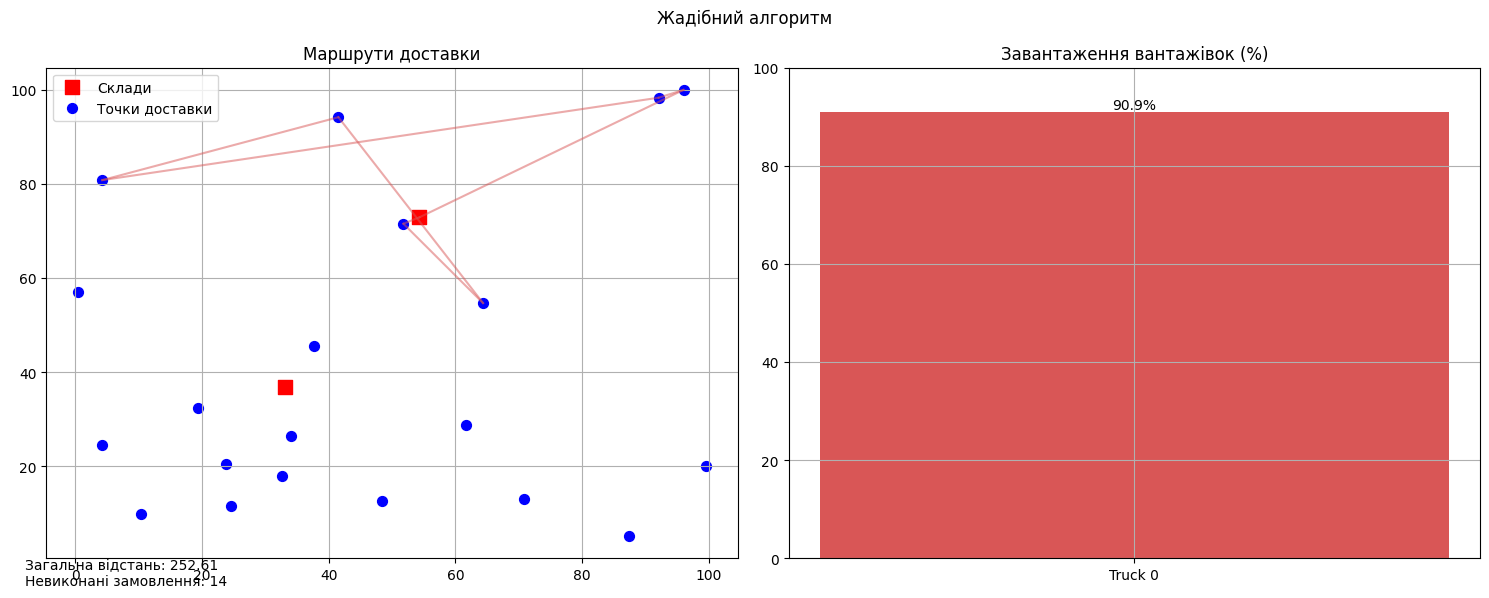

In [ ]:
# Створюємо тестову задачу
problem = generate_test_problem(
    num_warehouses=2,
    num_orders=20,
    num_trucks=1,
    seed=333
)


# Знаходимо жадібний розв'язок
solution = greedy_solution(problem)

# Виводимо результати
print(f"\nЗнайдено розв'язок:")
print(f"Загальна вартість: {solution.compute_total_cost():.2f}")
print(f"Кількість маршрутів: {len(solution.routes)}")
print(f"Невиконані замовлення: {len(solution.unassigned_orders)}")

print("\nДеталі маршрутів:")
for i, route in enumerate(solution.routes, 1):
    print(f"{i}. {route}")

# Візуалізуємо розв'язок
fig = visualize_solution(solution, "Жадібний алгоритм")

# Показуємо графік
plt.show()

## Local Search, Hill Climbing

In [ ]:
from copy import deepcopy

In [ ]:

class LocalSearchOperator:
    """Базовий клас для операцій локального пошуку."""

    @staticmethod
    def swap_orders(solution: Solution, route1_idx: int, order1_idx: int,
                   route2_idx: int, order2_idx: int) -> bool:
        """
        Обмінює два замовлення між маршрутами.
        Повертає True, якщо обмін можливий і був виконаний.
        """
        if route1_idx == route2_idx:
            return False

        route1 = solution.routes[route1_idx]
        route2 = solution.routes[route2_idx]

        if order1_idx >= len(route1.orders) or order2_idx >= len(route2.orders):
            return False

        order1 = route1.orders[order1_idx]
        order2 = route2.orders[order2_idx]

        # Перевіряємо можливість обміну (вантажопідйомність)
        new_load1 = route1.truck.current_load - order1.volume + order2.volume
        new_load2 = route2.truck.current_load - order2.volume + order1.volume

        if (new_load1 <= route1.truck.capacity and
            new_load2 <= route2.truck.capacity):
            # Виконуємо обмін
            route1.orders[order1_idx] = order2
            route2.orders[order2_idx] = order1

            # Оновлюємо завантаження
            route1.truck.current_load = new_load1
            route2.truck.current_load = new_load2
            return True

        return False

    @staticmethod
    def relocate_order(solution: Solution, from_route_idx: int,
                      order_idx: int, to_route_idx: int,
                      new_position: int) -> bool:
        """
        Переміщує замовлення з одного маршруту в інший.
        """
        if from_route_idx == to_route_idx:
            return False

        from_route = solution.routes[from_route_idx]
        to_route = solution.routes[to_route_idx]

        if order_idx >= len(from_route.orders):
            return False

        order = from_route.orders[order_idx]

        # Перевіряємо можливість переміщення
        new_load = to_route.truck.current_load + order.volume
        if new_load <= to_route.truck.capacity:
            # Видаляємо з початкового маршруту
            from_route.orders.pop(order_idx)
            from_route.truck.current_load -= order.volume

            # Додаємо до нового маршруту
            to_route.orders.insert(min(new_position, len(to_route.orders)), order)
            to_route.truck.current_load += order.volume
            return True

        return False

    @staticmethod
    def two_opt_swap(solution: Solution, route_idx: int, i: int, j: int) -> bool:
        """
        Виконує 2-opt swap в межах одного маршруту (перевертає частину маршруту).
        """
        route = solution.routes[route_idx]
        if i >= j or i < 0 or j >= len(route.orders):
            return False

        # Перевертаємо частину маршруту між i та j
        route.orders[i:j+1] = reversed(route.orders[i:j+1])
        return True


In [ ]:

def generate_neighbor(solution: Solution) -> Tuple[Solution, str]:
    """
    Генерує випадкового сусіда поточного розв'язку.
    Повертає (новий_розв'язок, тип_операції).
    """
    new_solution = deepcopy(solution)

    operation = random.choice(['swap', 'relocate', 'two_opt'])

    if operation == 'swap':
        if len(new_solution.routes) >= 2:
            route_indices = random.sample(range(len(new_solution.routes)), 2)  # Simplified route selection
            route1_idx, route2_idx = route_indices[0], route_indices[1]

            route1 = new_solution.routes[route1_idx]
            route2 = new_solution.routes[route2_idx]

            if route1.orders and route2.orders:  # Check for empty routes!
                order1_idx = random.randint(0, len(route1.orders) - 1)
                order2_idx = random.randint(0, len(route2.orders) - 1)

                if LocalSearchOperator.swap_orders(new_solution, route1_idx, order1_idx, route2_idx, order2_idx):
                    return new_solution, 'swap'

    elif operation == 'relocate':
        if len(new_solution.routes) >= 2:
            route_indices = random.sample(range(len(new_solution.routes)), 2)  # Simplified route selection
            from_route_idx, to_route_idx = route_indices[0], route_indices[1]

            from_route = new_solution.routes[from_route_idx]

            if from_route.orders:  # Check for empty route!
                order_idx = random.randint(0, len(from_route.orders) - 1)
                new_position = random.randint(0, len(new_solution.routes[to_route_idx].orders))

                if LocalSearchOperator.relocate_order(new_solution, from_route_idx, order_idx, to_route_idx, new_position):
                    return new_solution, 'relocate'

    elif operation == 'two_opt':
        for _ in range(3):  # Try up to 3 times
            route_idx = random.randint(0, len(new_solution.routes) - 1)
            route = new_solution.routes[route_idx]

            num_orders = len(route.orders)
            if num_orders >= 4:
                i = random.randint(0, num_orders - 2)
                j = random.randint(i + 1, num_orders - 1)

                if LocalSearchOperator.two_opt_swap(new_solution, route_idx, i, j):
                    return new_solution, 'two_opt'

        # If no suitable route was found after 3 tries, skip two_opt:
        return new_solution, None  # Or potentially try another operation

    # Якщо жодна операція не вдалася, повертаємо копію початкового розв'язку
    return new_solution, 'none'


In [ ]:

def hill_climbing(initial_solution: Solution,
                 max_iterations: int = 1000,
                 max_no_improve: int = 100) -> Solution:
    """
    Реалізує алгоритм Hill Climbing для покращення розв'язку.

    Args:
        initial_solution: початковий розв'язок
        max_iterations: максимальна кількість ітерацій
        max_no_improve: максимальна кількість ітерацій без покращення
    """
    current_solution = deepcopy(initial_solution)
    best_solution = deepcopy(current_solution)
    best_cost = current_solution.compute_total_cost()

    iterations = 0
    no_improve = 0

    while iterations < max_iterations and no_improve < max_no_improve:
        # Генеруємо сусіда
        neighbor, operation = generate_neighbor(current_solution)
        neighbor_cost = neighbor.compute_total_cost()

        # Якщо знайшли краще рішення
        if neighbor_cost < best_cost:
            best_solution = deepcopy(neighbor)
            best_cost = neighbor_cost
            current_solution = neighbor
            no_improve = 0
            print(f"Iteration {iterations}: Found better solution with {operation} "
                  f"operation. New cost: {best_cost:.2f}")
        else:
            no_improve += 1

        iterations += 1

    print(f"\nHill Climbing finished after {iterations} iterations")
    print(f"Initial cost: {initial_solution.compute_total_cost():.2f}")
    print(f"Final cost: {best_cost:.2f}")
    print(f"Improvement: {(initial_solution.compute_total_cost() - best_cost):.2f} "
          f"({(initial_solution.compute_total_cost() - best_cost) / initial_solution.compute_total_cost() * 100:.1f}%)")

    return best_solution



Початковий розв'язок:
Вартість: 11188.30
Iteration 12: Found better solution with two_opt operation. New cost: 11172.97
Iteration 16: Found better solution with two_opt operation. New cost: 11119.47
Iteration 28: Found better solution with two_opt operation. New cost: 11058.94
Iteration 103: Found better solution with two_opt operation. New cost: 10943.09
Iteration 197: Found better solution with two_opt operation. New cost: 10814.21
Iteration 202: Found better solution with two_opt operation. New cost: 10801.43
Iteration 256: Found better solution with two_opt operation. New cost: 10725.95
Iteration 361: Found better solution with two_opt operation. New cost: 10713.61
Iteration 664: Found better solution with swap operation. New cost: 10606.40
Iteration 1164: Found better solution with swap operation. New cost: 10334.53

Hill Climbing finished after 2165 iterations
Initial cost: 11188.30
Final cost: 10334.53
Improvement: 853.77 (7.6%)


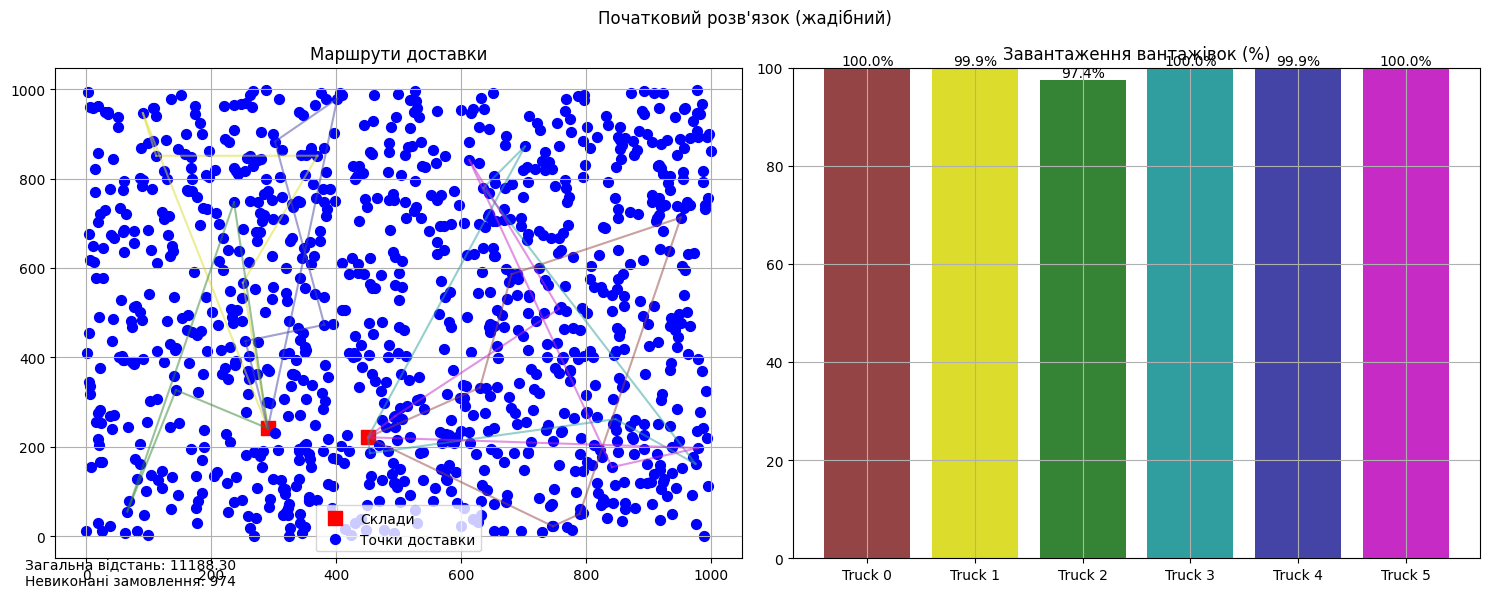

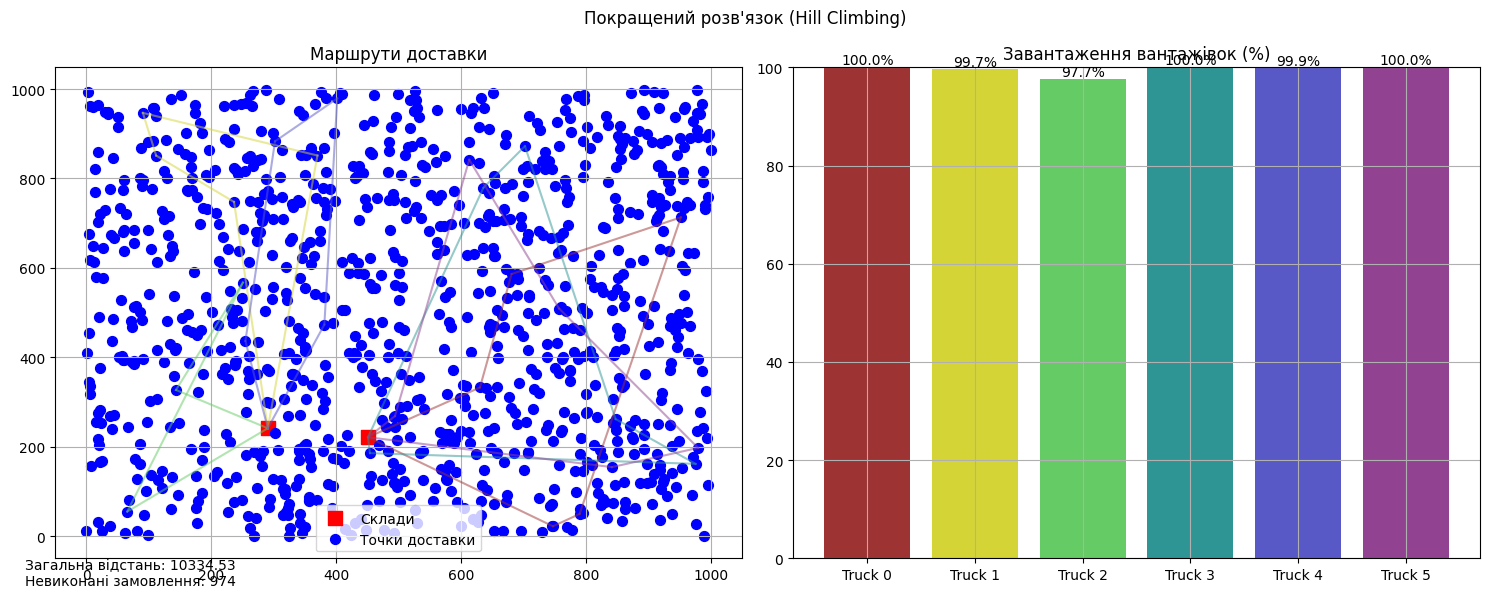


Деталі маршрутів initial_solution:
1. Route(truck=0, orders=[824, 916, 97, 150, 764], load=454.1/454.2)
2. Route(truck=1, orders=[809, 922, 525, 242], load=360.6/360.9)
3. Route(truck=2, orders=[456, 534, 48], load=297.2/305.1)
4. Route(truck=3, orders=[434, 790, 602, 227, 71], load=417.0/417.1)
5. Route(truck=4, orders=[13, 573, 196, 466], load=379.7/380.3)
6. Route(truck=5, orders=[971, 535, 825, 954, 770], load=482.5/482.5)

Деталі маршрутів improved_solution:
1. Route(truck=0, orders=[824, 916, 97, 150, 764], load=454.1/454.2)
2. Route(truck=1, orders=[48, 525, 242, 922], load=359.9/360.9)
3. Route(truck=2, orders=[456, 809, 534], load=298.0/305.1)
4. Route(truck=3, orders=[434, 602, 790, 71, 227], load=417.0/417.1)
5. Route(truck=4, orders=[13, 196, 466, 573], load=379.7/380.3)
6. Route(truck=5, orders=[971, 825, 535, 770, 954], load=482.5/482.5)


In [ ]:

# Створюємо тестову задачу
# problem = generate_test_problem(
#     num_warehouses=2,
#     num_orders=15,
#     num_trucks=4,
#     area_size=100,
#     seed=42
# )

problem = generate_test_problem(
    num_warehouses=2,
    num_orders=1000,
    num_trucks=6,
    area_size=1000,
    seed=300
)

# Знаходимо початковий розв'язок жадібним алгоритмом
initial_solution = greedy_solution(problem)
print("\nПочатковий розв'язок:")
print(f"Вартість: {initial_solution.compute_total_cost():.2f}")

# Покращуємо розв'язок за допомогою Hill Climbing
improved_solution = hill_climbing(initial_solution, 10000, 1000)

# Візуалізуємо початковий та покращений розв'язки
fig1 = visualize_solution(initial_solution, "Початковий розв'язок (жадібний)")
fig2 = visualize_solution(improved_solution, "Покращений розв'язок (Hill Climbing)")
plt.show()

print("\nДеталі маршрутів initial_solution:")
for i, route in enumerate(initial_solution.routes, 1):
    print(f"{i}. {route}")

print("\nДеталі маршрутів improved_solution:")
for i, route in enumerate(improved_solution.routes, 1):
    print(f"{i}. {route}")

## Simuleted Annealing

In [ ]:
import math

In [ ]:

@dataclass
class SimulatedAnnealingStats:
    """Клас для збору статистики роботи алгоритму."""
    iterations: int = 0
    accepted_moves: int = 0
    improving_moves: int = 0
    deteriorating_moves: int = 0
    temperature_history: List[float] = None
    cost_history: List[float] = None
    best_cost_history: List[float] = None

    def acceptance_rate(self) -> float:
        """Повертає відсоток прийнятих ходів."""
        return self.accepted_moves / self.iterations if self.iterations > 0 else 0

    def improvement_rate(self) -> float:
        """Повертає відсоток покращуючих ходів."""
        return self.improving_moves / self.iterations if self.iterations > 0 else 0


In [ ]:

class SimulatedAnnealing:
    """Реалізація алгоритму імітації відпалу."""

    def __init__(self,
                 initial_temp: float = 100.0,
                 final_temp: float = 1.0,
                 alpha: float = 0.98,
                 iterations_per_temp: int = 100,
                 max_iterations: int = 10000):
        """
        Args:
            initial_temp: початкова температура
            final_temp: кінцева температура
            alpha: коефіцієнт охолодження (0 < alpha < 1)
            iterations_per_temp: кількість ітерацій на кожній температурі
            max_iterations: максимальна кількість ітерацій
        """
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.alpha = alpha
        self.iterations_per_temp = iterations_per_temp
        self.max_iterations = max_iterations
        self.stats = None

    def _acceptance_probability(self,
                              current_cost: float,
                              new_cost: float,
                              temperature: float) -> float:
        """Обчислює ймовірність прийняття нового розв'язку."""
        if new_cost < current_cost:
            return 1.0
        return math.exp(-(new_cost - current_cost) / temperature)

    def _initialize_stats(self):
        """Ініціалізує збір статистики."""
        self.stats = SimulatedAnnealingStats()
        self.stats.temperature_history = []
        self.stats.cost_history = []
        self.stats.best_cost_history = []

    def optimize(self, initial_solution: Solution) -> Tuple[Solution, SimulatedAnnealingStats]:
        """
        Виконує оптимізацію розв'язку методом імітації відпалу.

        Args:
            initial_solution: початковий розв'язок

        Returns:
            Tuple[Solution, SimulatedAnnealingStats]: кращий знайдений розв'язок та статистика
        """
        self._initialize_stats()

        current_solution = deepcopy(initial_solution)
        best_solution = deepcopy(current_solution)

        current_cost = current_solution.compute_total_cost()
        best_cost = current_cost

        temperature = self.initial_temp
        iteration = 0

        while (iteration < self.max_iterations and
               temperature > self.final_temp):

            for _ in range(self.iterations_per_temp):
                # Генеруємо сусідній розв'язок
                new_solution, operation = generate_neighbor(current_solution)
                new_cost = new_solution.compute_total_cost()

                # Обчислюємо ймовірність прийняття
                acceptance_prob = self._acceptance_probability(
                    current_cost, new_cost, temperature
                )

                self.stats.iterations += 1

                # Вирішуємо, чи приймати новий розв'язок
                if random.random() < acceptance_prob:
                    current_solution = new_solution
                    current_cost = new_cost
                    self.stats.accepted_moves += 1

                    if new_cost < current_cost:
                        self.stats.improving_moves += 1
                    else:
                        self.stats.deteriorating_moves += 1

                    # Оновлюємо найкращий розв'язок
                    if new_cost < best_cost:
                        best_solution = deepcopy(new_solution)
                        best_cost = new_cost
                        print(f"Iteration {iteration}: Found better solution with {operation} "
                              f"operation. New cost: {best_cost:.2f}")

                # Зберігаємо статистику
                self.stats.temperature_history.append(temperature)
                self.stats.cost_history.append(current_cost)
                self.stats.best_cost_history.append(best_cost)

                iteration += 1
                if iteration >= self.max_iterations:
                    break

            # Зменшуємо температуру
            temperature *= self.alpha

        print(f"\nSimulated Annealing finished after {iteration} iterations")
        print(f"Initial cost: {initial_solution.compute_total_cost():.2f}")
        print(f"Final cost: {best_cost:.2f}")
        print(f"Improvement: {(initial_solution.compute_total_cost() - best_cost):.2f} "
              f"({(initial_solution.compute_total_cost() - best_cost) / initial_solution.compute_total_cost() * 100:.1f}%)")
        print(f"Acceptance rate: {self.stats.acceptance_rate():.1%}")
        print(f"Improvement rate: {self.stats.improvement_rate():.1%}")

        return best_solution, self.stats

In [ ]:

def visualize_sa_stats(stats: SimulatedAnnealingStats):
    """Візуалізує статистику роботи алгоритму імітації відпалу."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Графік температури
    ax1.plot(stats.temperature_history, label='Temperature')
    ax1.set_yscale('log')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Temperature')
    ax1.set_title('Temperature Cooling Schedule')
    ax1.grid(True)
    ax1.legend()

    # Графік вартості розв'язку
    ax2.plot(stats.cost_history, label='Current Cost', alpha=0.5)
    ax2.plot(stats.best_cost_history, label='Best Cost', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Solution Cost')
    ax2.set_title('Solution Cost over Iterations')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    return fig


Початковий розв'язок:
Вартість: 408.25
Iteration 3: Found better solution with two_opt operation. New cost: 407.22
Iteration 953: Found better solution with two_opt operation. New cost: 403.09
Iteration 3888: Found better solution with relocate operation. New cost: 391.98

Simulated Annealing finished after 5000 iterations
Initial cost: 408.25
Final cost: 391.98
Improvement: 16.27 (4.0%)
Acceptance rate: 63.4%
Improvement rate: 0.0%


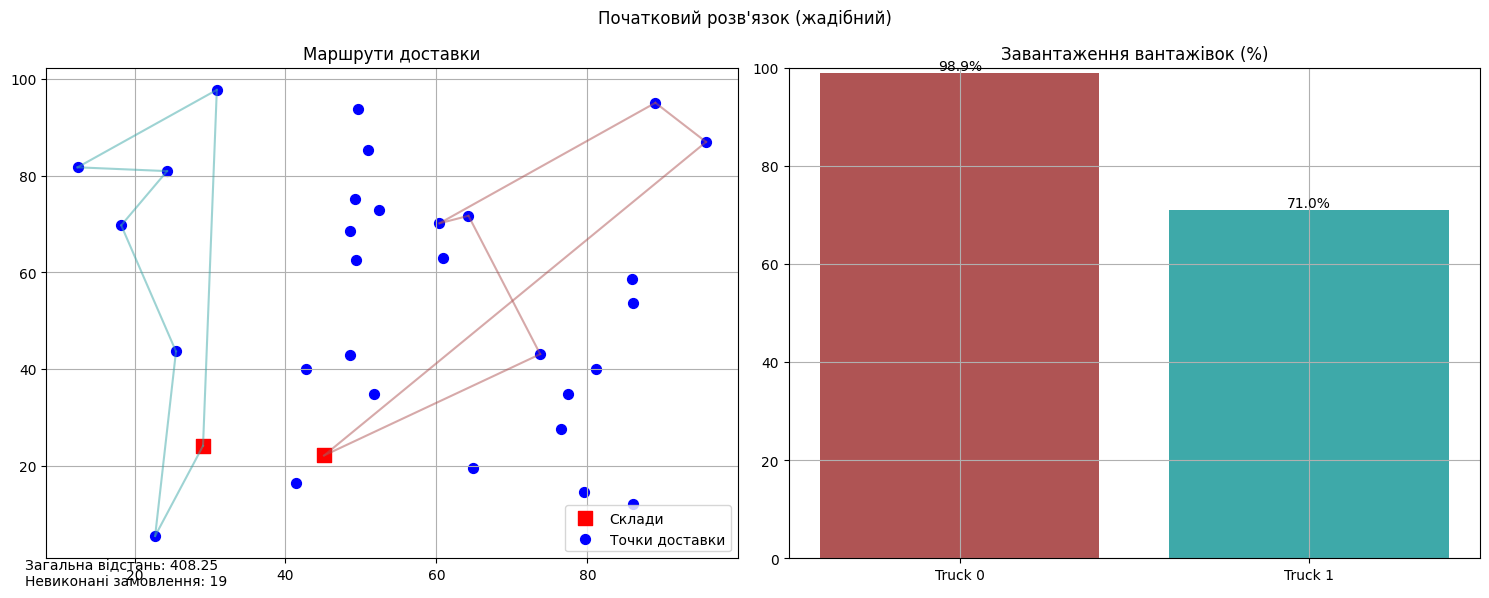

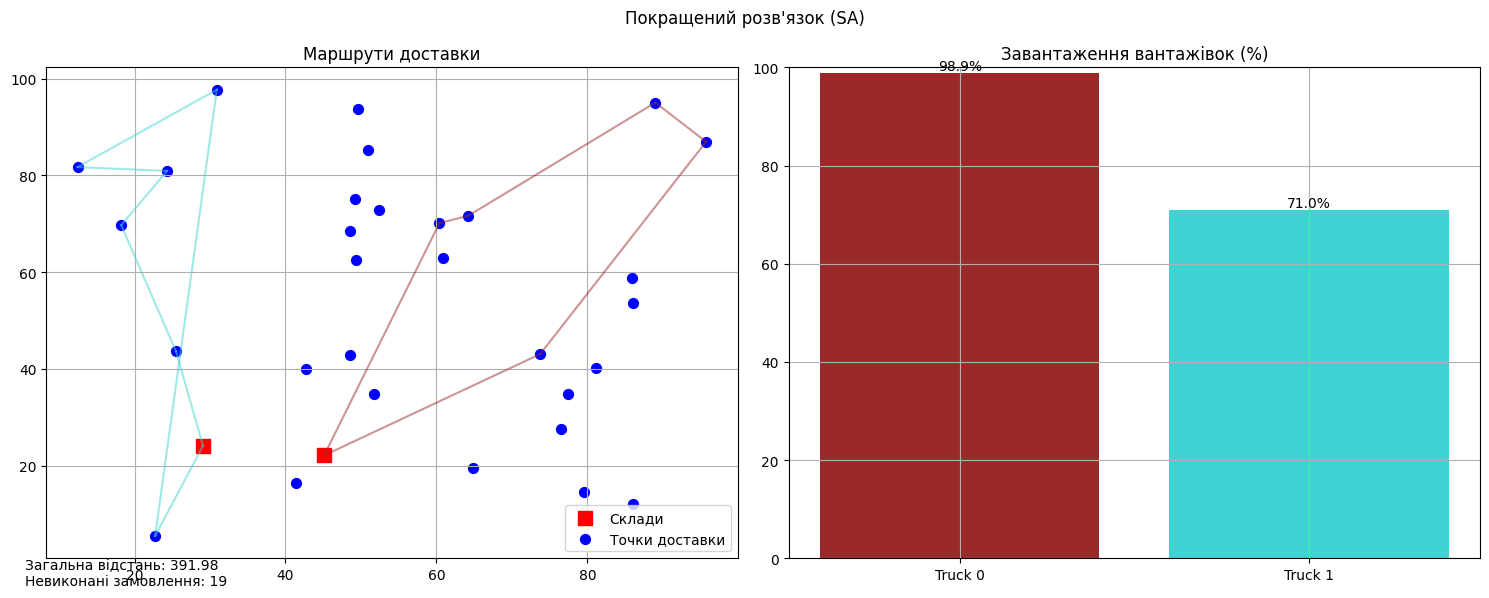

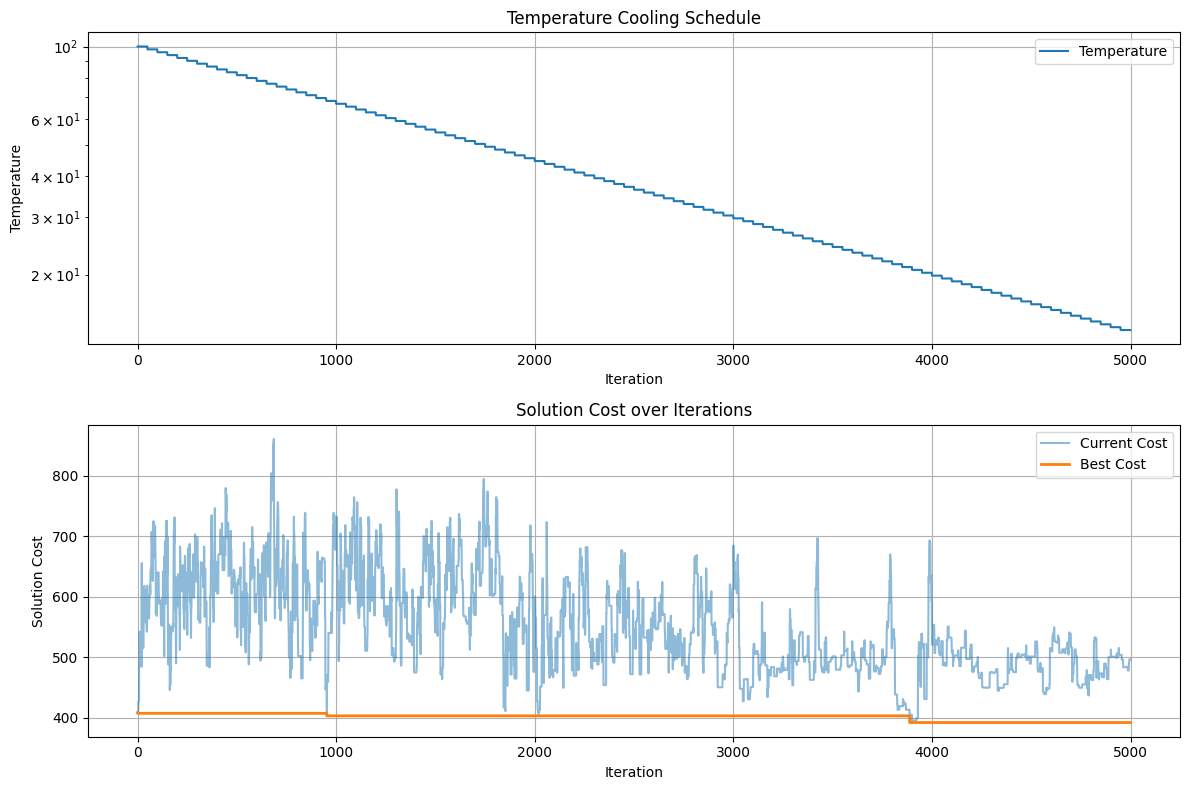

In [ ]:
# Створюємо тестову задачу
# problem = generate_test_problem(
#     num_warehouses=2,
#     num_orders=15,
#     num_trucks=4,
#     area_size=100,
#     seed=300
# )

problem = generate_test_problem(
    num_warehouses=2,
    num_orders=30,
    num_trucks=2,
    area_size=100,
    seed=300
)

# Знаходимо початковий розв'язок жадібним алгоритмом
initial_solution = greedy_solution(problem)
print("\nПочатковий розв'язок:")
print(f"Вартість: {initial_solution.compute_total_cost():.2f}")

# Налаштовуємо та запускаємо імітацію відпалу
sa = SimulatedAnnealing(
    initial_temp=100.0,
    final_temp=1.0,
    alpha=0.98,
    iterations_per_temp=50,
    max_iterations=5000
)

improved_solution, stats = sa.optimize(initial_solution)

# Візуалізуємо результати
fig1 = visualize_solution(initial_solution, "Початковий розв'язок (жадібний)")
fig2 = visualize_solution(improved_solution, "Покращений розв'язок (SA)")
fig3 = visualize_sa_stats(stats)
plt.show()

## Paralel Optimization Implementation

In [ ]:
import pandas as pd
import seaborn as sns
import itertools
import time
from multiprocessing import Pool, cpu_count
from dataclasses import asdict

In [ ]:
class ExperimentResult(NamedTuple):
    """Результати одного експерименту."""
    params: Dict
    initial_cost: float
    final_cost: float
    improvement: float
    improvement_percent: float
    runtime: float
    iterations: int
    acceptance_rate: float
    improvement_rate: float


In [ ]:

def run_single_experiment(args: Tuple[Solution, Dict]) -> ExperimentResult:
    """
    Запускає один експеримент з заданими параметрами.

    Args:
        args: кортеж (початковий_розв'язок, параметри)
    """
    initial_solution, params = args
    start_time = time.time()

    # Створюємо і запускаємо SA з заданими параметрами
    sa = SimulatedAnnealing(**params)
    final_solution, stats = sa.optimize(initial_solution)

    runtime = time.time() - start_time
    initial_cost = initial_solution.compute_total_cost()
    final_cost = final_solution.compute_total_cost()
    improvement = initial_cost - final_cost

    return ExperimentResult(
        params=params,
        initial_cost=initial_cost,
        final_cost=final_cost,
        improvement=improvement,
        improvement_percent=(improvement / initial_cost * 100),
        runtime=runtime,
        iterations=stats.iterations,
        acceptance_rate=stats.acceptance_rate(),
        improvement_rate=stats.improvement_rate()
    )


In [ ]:

class ParallelOptimizer:
    """Клас для паралельного запуску оптимізації з різними параметрами."""

    def __init__(self, problem: LogisticsProblem):
        self.problem = problem
        self.initial_solution = None
        self.results: List[ExperimentResult] = []

    def generate_parameter_grid(self) -> List[Dict]:
        """Генерує сітку параметрів для експериментів."""
        param_grid = {
            'initial_temp': [50.0, 100.0, 200.0],
            'final_temp': [0.1, 1.0, 5.0],
            'alpha': [0.95, 0.98, 0.99],
            'iterations_per_temp': [50, 100],
            'max_iterations': [5000]
        }

        # Створюємо всі можливі комбінації параметрів
        keys = param_grid.keys()
        values = param_grid.values()
        combinations = list(itertools.product(*values))

        return [dict(zip(keys, combo)) for combo in combinations]

    def run_experiments(self, n_processes: int = None) -> pd.DataFrame:
        """
        Запускає експерименти паралельно.

        Args:
            n_processes: кількість процесів (за замовчуванням - кількість ядер)
        """
        if n_processes is None:
            n_processes = cpu_count()

        if self.initial_solution is None:
            self.initial_solution = greedy_solution(self.problem)

        # Генеруємо параметри
        param_grid = self.generate_parameter_grid()
        print(f"Running {len(param_grid)} experiments using {n_processes} processes...")

        # Готуємо аргументи для кожного експерименту
        args = [(deepcopy(self.initial_solution), params)
                for params in param_grid]

        # Запускаємо експерименти паралельно
        with Pool(n_processes) as pool:
            self.results = pool.map(run_single_experiment, args)

        # Перетворюємо результати в DataFrame
        df_results = self._results_to_dataframe()

        return df_results

    def _results_to_dataframe(self) -> pd.DataFrame:
        """Перетворює результати в pandas DataFrame."""
        records = []
        for result in self.results:
            record = {
                'initial_cost': result.initial_cost,
                'final_cost': result.final_cost,
                'improvement': result.improvement,
                'improvement_percent': result.improvement_percent,
                'runtime': result.runtime,
                'iterations': result.iterations,
                'acceptance_rate': result.acceptance_rate,
                'improvement_rate': result.improvement_rate,
                **result.params  # розпаковуємо параметри
            }
            records.append(record)

        return pd.DataFrame(records)


In [ ]:

def visualize_experiment_results(df: pd.DataFrame):
    """Візуалізує результати експериментів."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Покращення в залежності від початкової температури
    sns.boxplot(x='initial_temp', y='improvement_percent', data=df, ax=ax1)
    ax1.set_title('Improvement vs Initial Temperature')
    ax1.set_ylabel('Improvement (%)')

    # 2. Час виконання в залежності від кількості ітерацій
    sns.scatterplot(x='iterations', y='runtime',
                   hue='alpha', size='initial_temp',
                   data=df, ax=ax2)
    ax2.set_title('Runtime vs Iterations')

    # 3. Теплова карта середнього покращення
    pivot_temp = df.pivot_table(
        values='improvement_percent',
        index='alpha',
        columns='initial_temp',
        aggfunc='mean'
    )
    sns.heatmap(pivot_temp, annot=True, fmt='.1f', ax=ax3)
    ax3.set_title('Average Improvement (%) by Parameters')

    # 4. Гістограма розподілу покращення
    sns.histplot(data=df, x='improvement_percent', bins=20, ax=ax4)
    ax4.set_title('Distribution of Improvements')
    ax4.set_xlabel('Improvement (%)')

    plt.tight_layout()
    return fig


Running 54 experiments using 2 processes...
Iteration 1671: Found better solution with two_opt operation. New cost: 615.02
Iteration 1756: Found better solution with two_opt operation. New cost: 603.87
Iteration 1769: Found better solution with two_opt operation. New cost: 602.33
Iteration 2068: Found better solution with two_opt operation. New cost: 595.35
Iteration 2059: Found better solution with relocate operation. New cost: 582.70
Iteration 2086: Found better solution with swap operation. New cost: 565.09
Iteration 2335: Found better solution with two_opt operation. New cost: 590.28
Iteration 2394: Found better solution with relocate operation. New cost: 562.20
Iteration 2573: Found better solution with two_opt operation. New cost: 582.11
Iteration 3135: Found better solution with relocate operation. New cost: 554.21
Iteration 3358: Found better solution with two_opt operation. New cost: 533.59
Iteration 3361: Found better solution with two_opt operation. New cost: 526.18
Iteratio

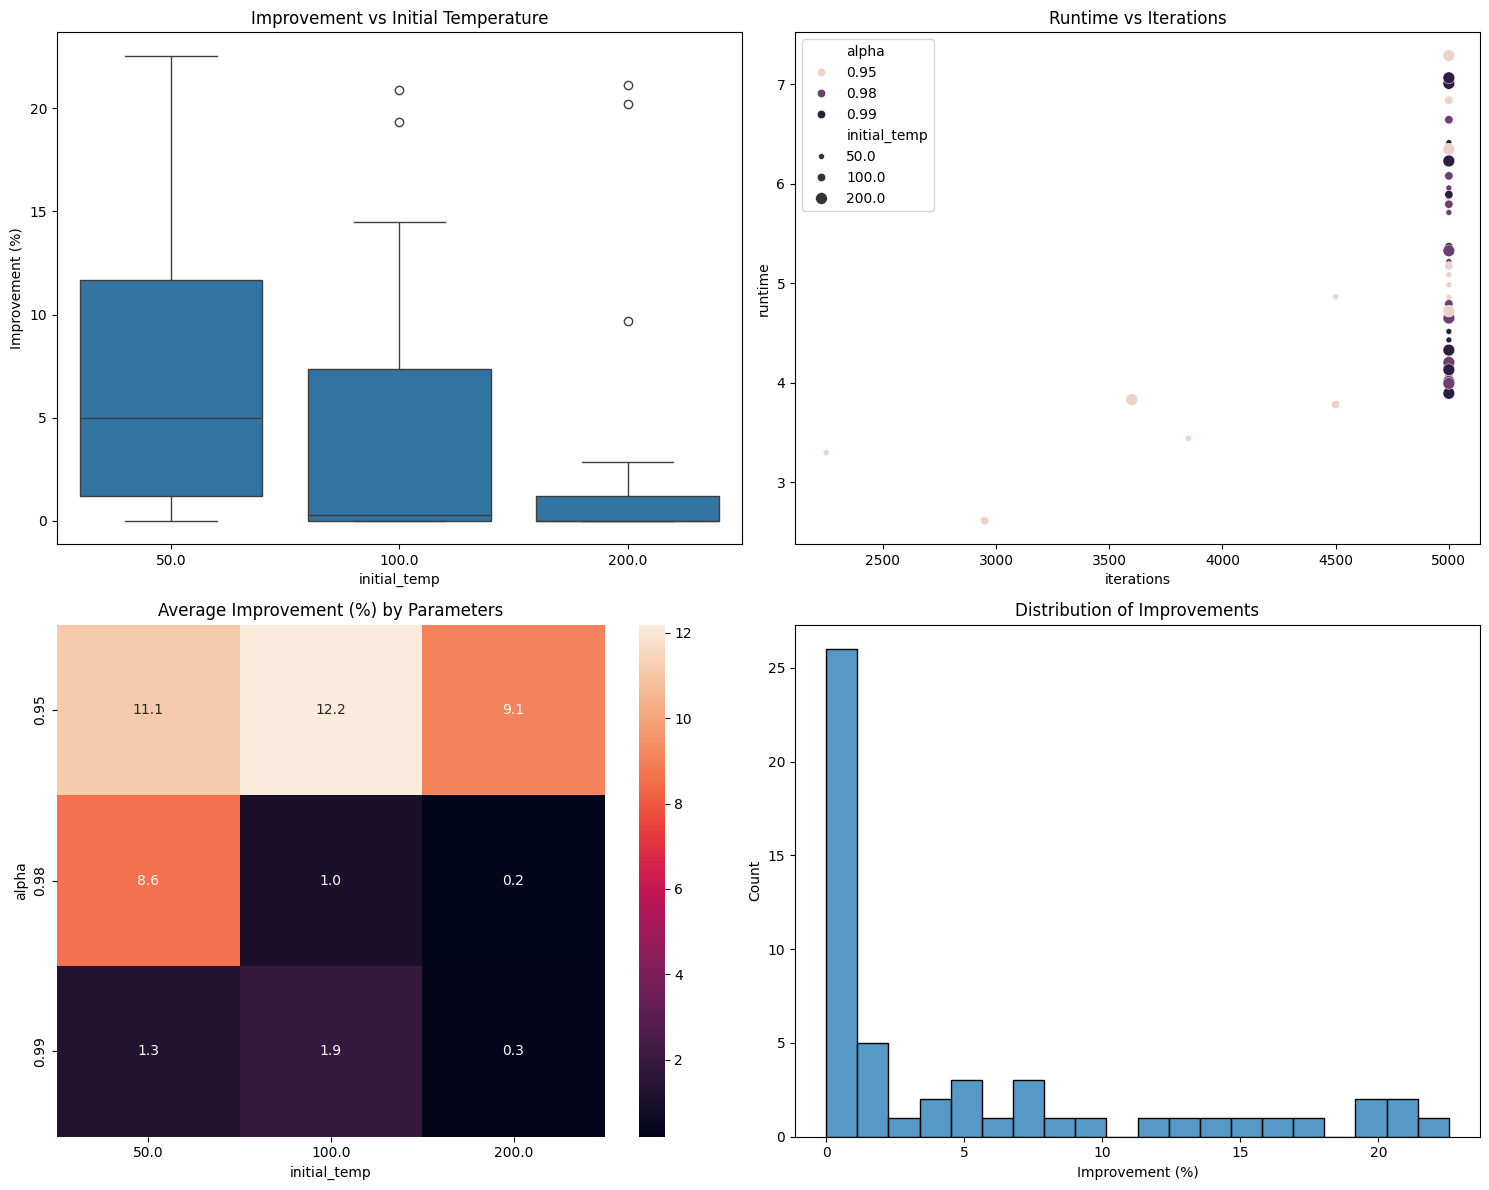

In [ ]:

# Створюємо тестову задачу
problem = generate_test_problem(
    num_warehouses=2,
    num_orders=20,
    num_trucks=4,
    area_size=100,
    seed=300
)

# Створюємо оптимізатор
optimizer = ParallelOptimizer(problem)

# Запускаємо експерименти
results_df = optimizer.run_experiments()

# Виводимо найкращі результати
best_result = results_df.loc[results_df['improvement_percent'].idxmax()]
print("\nНайкращий результат:")
print(f"Покращення: {best_result['improvement_percent']:.1f}%")
print(f"Час виконання: {best_result['runtime']:.1f} сек")
print("\nПараметри:")
for param in ['initial_temp', 'final_temp', 'alpha', 'iterations_per_temp']:
    print(f"{param}: {best_result[param]}")

# Візуалізуємо результати
fig = visualize_experiment_results(results_df)
plt.show()


In [ ]:
results_df.sort_values(by='improvement_percent', ascending=False)

,initial_cost,final_cost,improvement,improvement_percent,runtime,iterations,acceptance_rate,improvement_rate,initial_temp,final_temp,alpha,iterations_per_temp,max_iterations
6,615.44318,476.633463,138.809717,22.554433,3.442452,3850,0.541299,0.0,50.0,1.0,0.95,50,5000
36,615.44318,485.475645,129.967536,21.117715,4.172639,5000,0.624800,0.0,200.0,0.1,0.95,50,5000
24,615.44318,486.975517,128.467663,20.874009,3.781899,4500,0.575556,0.0,100.0,1.0,0.95,50,5000
42,615.44318,491.118709,124.324471,20.200804,7.289947,5000,0.635200,0.0,200.0,1.0,0.95,50,5000
19,615.44318,496.366820,119.076360,19.348067,5.176960,5000,0.681000,0.0,100.0,0.1,0.95,100,5000
0,615.44318,506.333794,109.109386,17.728588,4.986041,5000,0.474000,0.0,50.0,0.1,0.95,50,5000
2,615.44318,512.240907,103.202273,16.768774,5.960189,5000,0.578200,0.0,50.0,0.1,0.98,50,5000
8,615.44318,518.655881,96.787299,15.726439,5.220526,5000,0.580400,0.0,50.0,1.0,0.98,50,5000
18,615.44318,526.234604,89.208576,14.495014,4.192985,5000,0.509200,0.0,100.0,0.1,0.95,50,5000
14,615.44318,536.398713,79.044467,12.843504,4.238099,5000,0.555200,0.0,50.0,5.0,0.98,50,5000


## Adaptive  SA Implementation

In [ ]:
@dataclass
class AdaptiveParameters:
    """Параметри для адаптивного налаштування."""
    temperature: float
    acceptance_rate: float = 0.0
    improvement_rate: float = 0.0
    last_improvements: List[float] = field(default_factory=list)
    stagnation_counter: int = 0

    # Цільові значення для адаптації
    target_acceptance_rate: float = 0.3  # бажаний рівень прийняття нових розв'язків
    min_temperature: float = 0.1
    max_temperature: float = 1000.0

    # Параметри для виявлення стагнації
    stagnation_window: int = 100  # вікно для аналізу стагнації
    stagnation_threshold: float = 0.001  # поріг відносного покращення

    def update_rates(self, accepted: bool, improved: bool):
        """Оновлює статистику прийняття та покращення."""
        # Експоненційне згладжування для rates
        alpha = 0.02  # коефіцієнт згладжування
        self.acceptance_rate = (1 - alpha) * self.acceptance_rate + alpha * float(accepted)
        self.improvement_rate = (1 - alpha) * self.improvement_rate + alpha * float(improved)

    def adapt_temperature(self):
        """Адаптивно налаштовує температуру."""
        if self.acceptance_rate < self.target_acceptance_rate - 0.1:
            # Збільшуємо температуру, якщо приймається замало розв'язків
            self.temperature *= 1.1
        elif self.acceptance_rate > self.target_acceptance_rate + 0.1:
            # Зменшуємо температуру, якщо приймається забагато розв'язків
            self.temperature *= 0.9

        # Обмежуємо температуру
        self.temperature = np.clip(self.temperature,
                                 self.min_temperature,
                                 self.max_temperature)

    def check_stagnation(self, current_cost: float) -> bool:
        """Перевіряє наявність стагнації."""
        self.last_improvements.append(current_cost)
        if len(self.last_improvements) > self.stagnation_window:
            self.last_improvements.pop(0)

            # Обчислюємо відносне покращення
            if len(self.last_improvements) >= 2:
                relative_improvement = abs(
                    (self.last_improvements[-1] - self.last_improvements[0]) /
                    self.last_improvements[0]
                )

                if relative_improvement < self.stagnation_threshold:
                    self.stagnation_counter += 1
                    return True

        self.stagnation_counter = 0
        return False

    def handle_stagnation(self):
        """Реагує на стагнацію."""
        # Збільшуємо температуру для диверсифікації пошуку
        self.temperature *= 2.0
        self.temperature = min(self.temperature, self.max_temperature)

        # Скидаємо лічильники
        self.last_improvements.clear()
        self.stagnation_counter = 0


In [ ]:

class AdaptiveSimulatedAnnealing:
    """Реалізація адаптивного алгоритму імітації відпалу."""

    def __init__(self,
                 initial_temp: float = 100.0,
                 max_iterations: int = 10000,
                 max_stagnation_iterations: int = 1000):
        """
        Args:
            initial_temp: початкова температура
            max_iterations: максимальна кількість ітерацій
            max_stagnation_iterations: максимальна кількість ітерацій стагнації
        """
        self.params = AdaptiveParameters(temperature=initial_temp)
        self.max_iterations = max_iterations
        self.max_stagnation_iterations = max_stagnation_iterations
        self.stats = None

    def _initialize_stats(self):
        """Ініціалізує статистику."""
        self.stats = {
            'iterations': [],
            'temperature': [],
            'current_cost': [],
            'best_cost': [],
            'acceptance_rate': [],
            'improvement_rate': [],
            'stagnation_events': []
        }

    def _update_stats(self, iteration: int, current_cost: float,
                     best_cost: float, stagnation: bool):
        """Оновлює статистику."""
        self.stats['iterations'].append(iteration)
        self.stats['temperature'].append(self.params.temperature)
        self.stats['current_cost'].append(current_cost)
        self.stats['best_cost'].append(best_cost)
        self.stats['acceptance_rate'].append(self.params.acceptance_rate)
        self.stats['improvement_rate'].append(self.params.improvement_rate)
        self.stats['stagnation_events'].append(stagnation)

    def _acceptance_probability(self, current_cost: float,
                              new_cost: float) -> float:
        """Обчислює ймовірність прийняття нового розв'язку."""
        if new_cost < current_cost:
            return 1.0
        return math.exp(-(new_cost - current_cost) / self.params.temperature)

    def optimize(self, initial_solution: Solution) -> Tuple[Solution, Dict]:
        """
        Виконує оптимізацію розв'язку адаптивним методом імітації відпалу.

        Returns:
            Tuple[Solution, Dict]: оптимальний розв'язок та статистика
        """
        self._initialize_stats()

        current_solution = deepcopy(initial_solution)
        best_solution = deepcopy(current_solution)

        current_cost = current_solution.compute_total_cost()
        best_cost = current_cost

        iteration = 0
        consecutive_stagnation = 0

        while iteration < self.max_iterations:
            # Генеруємо сусідній розв'язок
            new_solution, operation = generate_neighbor(current_solution)
            new_cost = new_solution.compute_total_cost()

            # Обчислюємо ймовірність прийняття
            acceptance_prob = self._acceptance_probability(current_cost, new_cost)

            # Вирішуємо, чи приймати новий розв'язок
            accepted = False
            improved = False

            if random.random() < acceptance_prob:
                accepted = True
                if new_cost < current_cost:
                    improved = True

                current_solution = new_solution
                current_cost = new_cost

                # Оновлюємо найкращий розв'язок
                if new_cost < best_cost:
                    best_solution = deepcopy(new_solution)
                    best_cost = new_cost
                    print(f"Iteration {iteration}: Found better solution with {operation} "
                          f"operation. New cost: {best_cost:.2f}")

            # Оновлюємо статистику
            self.params.update_rates(accepted, improved)

            # Перевіряємо стагнацію
            stagnation = self.params.check_stagnation(current_cost)
            if stagnation:
                consecutive_stagnation += 1
                if consecutive_stagnation >= self.max_stagnation_iterations:
                    print(f"Stopping due to prolonged stagnation after {iteration} iterations")
                    break
                self.params.handle_stagnation()
            else:
                consecutive_stagnation = 0

            # Адаптуємо параметри
            self.params.adapt_temperature()

            # Зберігаємо статистику
            self._update_stats(iteration, current_cost, best_cost, stagnation)

            iteration += 1

        print(f"\nAdaptive Simulated Annealing finished after {iteration} iterations")
        print(f"Initial cost: {initial_solution.compute_total_cost():.2f}")
        print(f"Final cost: {best_cost:.2f}")
        print(f"Improvement: {(initial_solution.compute_total_cost() - best_cost):.2f} "
              f"({(initial_solution.compute_total_cost() - best_cost) / initial_solution.compute_total_cost() * 100:.1f}%)")

        return best_solution, self.stats


In [ ]:

def visualize_adaptive_sa_stats(stats: Dict):
    """Візуалізує статистику роботи адаптивного алгоритму."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Графік температури
    ax1.plot(stats['iterations'], stats['temperature'], label='Temperature')
    ax1.set_yscale('log')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Temperature')
    ax1.set_title('Adaptive Temperature')
    ax1.grid(True)

    # 2. Графік вартості розв'язку
    ax2.plot(stats['iterations'], stats['current_cost'],
             label='Current Cost', alpha=0.5)
    ax2.plot(stats['iterations'], stats['best_cost'],
             label='Best Cost', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Solution Cost')
    ax2.set_title('Solution Cost over Iterations')
    ax2.grid(True)
    ax2.legend()

    # 3. Графік рівнів прийняття
    ax3.plot(stats['iterations'], stats['acceptance_rate'],
             label='Acceptance Rate')
    ax3.plot(stats['iterations'], stats['improvement_rate'],
             label='Improvement Rate')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Rate')
    ax3.set_title('Acceptance and Improvement Rates')
    ax3.grid(True)
    ax3.legend()

    # 4. Графік подій стагнації
    stagnation_events = np.array(stats['stagnation_events']).astype(int)
    ax4.plot(stats['iterations'], stagnation_events,
             label='Stagnation Events', drawstyle='steps-post')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Stagnation')
    ax4.set_title('Stagnation Events')
    ax4.grid(True)

    plt.tight_layout()
    return fig



Початковий розв'язок:
Вартість: 615.44
Iteration 258: Found better solution with two_opt operation. New cost: 603.88
Iteration 265: Found better solution with swap operation. New cost: 595.55
Iteration 278: Found better solution with two_opt operation. New cost: 595.55
Iteration 283: Found better solution with swap operation. New cost: 592.51
Iteration 305: Found better solution with swap operation. New cost: 547.69
Iteration 332: Found better solution with two_opt operation. New cost: 536.81
Iteration 368: Found better solution with two_opt operation. New cost: 536.72
Iteration 749: Found better solution with two_opt operation. New cost: 498.55
Iteration 987: Found better solution with swap operation. New cost: 498.47
Iteration 1061: Found better solution with two_opt operation. New cost: 487.26
Iteration 1095: Found better solution with two_opt operation. New cost: 486.51
Iteration 1225: Found better solution with two_opt operation. New cost: 470.58
Iteration 1497: Found better solu

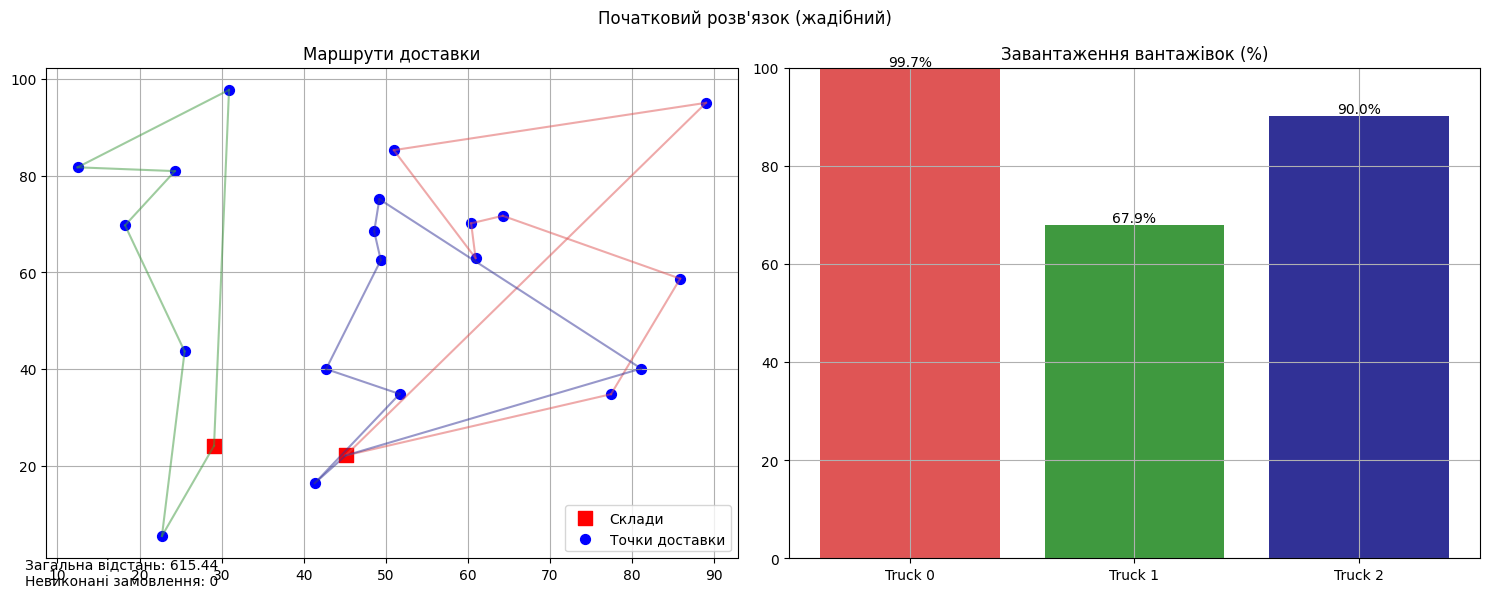

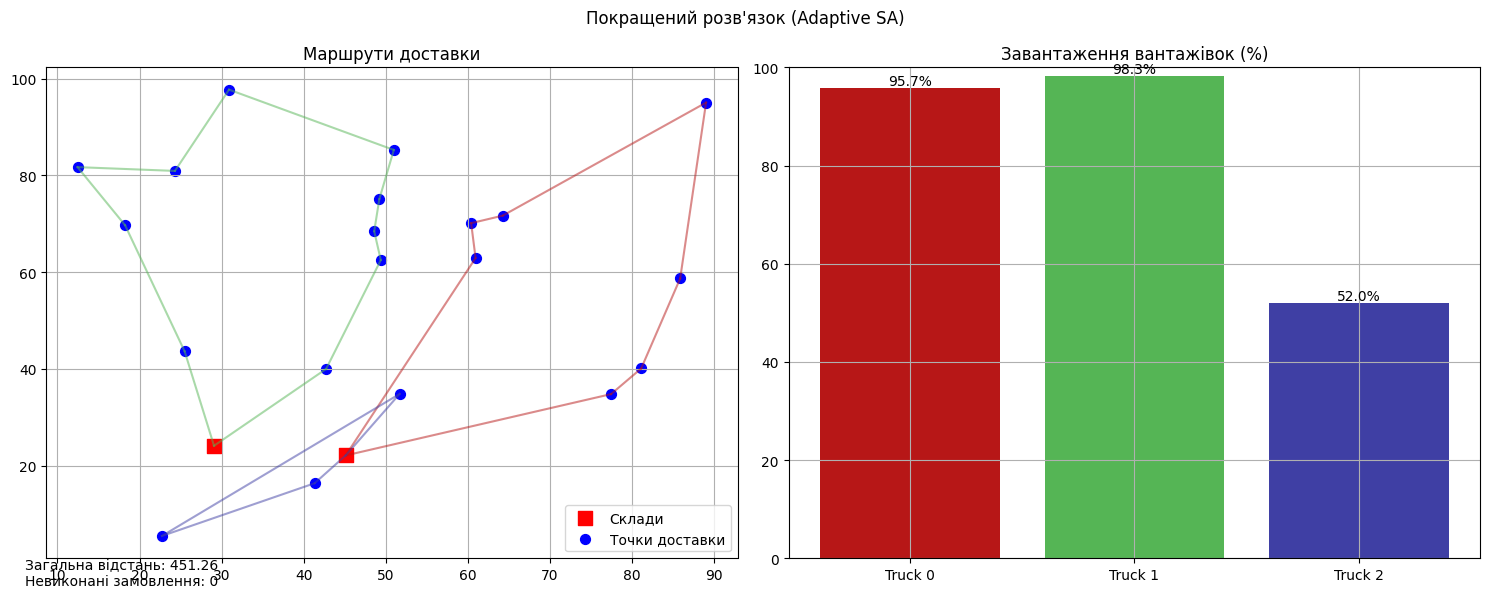

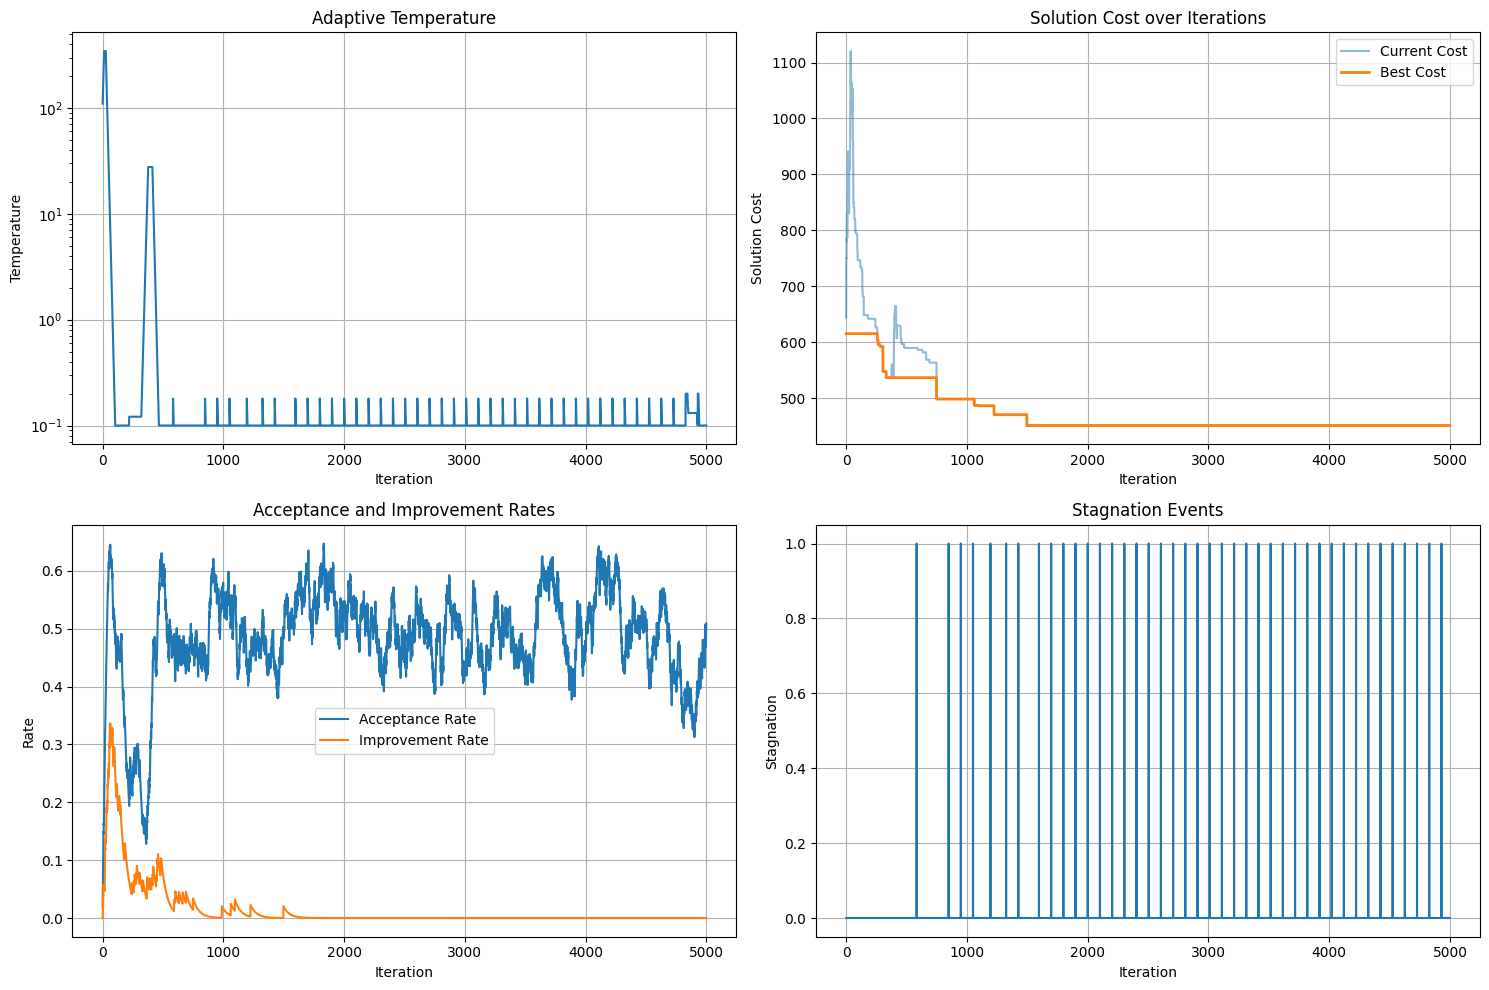

In [ ]:


# Створюємо тестову задачу
problem = generate_test_problem(
    num_warehouses=2,
    num_orders=20,
    num_trucks=4,
    area_size=100,
    seed=300
)

# Знаходимо початковий розв'язок жадібним алгоритмом
initial_solution = greedy_solution(problem)
print("\nПочатковий розв'язок:")
print(f"Вартість: {initial_solution.compute_total_cost():.2f}")

# Налаштовуємо та запускаємо адаптивну імітацію відпалу
adaptive_sa = AdaptiveSimulatedAnnealing(
    initial_temp=100.0,
    max_iterations=5000,
    max_stagnation_iterations=500
)

improved_solution, stats = adaptive_sa.optimize(initial_solution)

# Візуалізуємо результати
fig1 = visualize_solution(initial_solution, "Початковий розв'язок (жадібний)")
fig2 = visualize_solution(improved_solution, "Покращений розв'язок (Adaptive SA)")
fig3 = visualize_adaptive_sa_stats(stats)
plt.show()


## Optimization Methods Comparison

In [ ]:
from abc import ABC, abstractmethod
from time import time

In [ ]:

@dataclass
class OptimizationMetrics:
    """Метрики якості розв'язку."""
    total_distance: float
    max_route_length: float
    avg_route_length: float
    std_route_length: float
    total_load: float
    load_utilization: float
    num_routes: int
    unassigned_orders: int
    computation_time: float
    num_iterations: int

    @classmethod
    def calculate(cls, solution: Solution, computation_time: float,
                 num_iterations: int) -> 'OptimizationMetrics':
        """Обчислює всі метрики для розв'язку."""
        # Загальна відстань
        total_distance = solution.compute_total_cost()

        # Метрики маршрутів
        route_lengths = []
        total_load = 0
        total_capacity = 0

        for route in solution.routes:
            # Довжина маршруту
            length = 0
            if route.orders:
                # Від складу до першої точки
                length += solution.problem.distance(route.warehouse,
                                                 route.orders[0].delivery_point)

                # Між точками маршруту
                for i in range(len(route.orders) - 1):
                    length += solution.problem.distance(
                        route.orders[i].delivery_point,
                        route.orders[i + 1].delivery_point
                    )

                # Від останньої точки до складу
                length += solution.problem.distance(
                    route.orders[-1].delivery_point,
                    route.warehouse
                )

            route_lengths.append(length)
            total_load += route.truck.current_load
            total_capacity += route.truck.capacity

        return cls(
            total_distance=total_distance,
            max_route_length=max(route_lengths) if route_lengths else 0,
            avg_route_length=np.mean(route_lengths) if route_lengths else 0,
            std_route_length=np.std(route_lengths) if route_lengths else 0,
            total_load=total_load,
            load_utilization=total_load / total_capacity if total_capacity > 0 else 0,
            num_routes=len(solution.routes),
            unassigned_orders=len(solution.unassigned_orders),
            computation_time=computation_time,
            num_iterations=num_iterations
        )


In [ ]:

class Optimizer(ABC):
    """Базовий клас для всіх оптимізаторів."""

    @abstractmethod
    def optimize(self, initial_solution: Solution) -> Tuple[Solution, Dict]:
        """Виконує оптимізацію."""
        pass

    @property
    @abstractmethod
    def name(self) -> str:
        """Повертає назву оптимізатора."""
        pass

class HillClimbingOptimizer(Optimizer):
    """Hill Climbing оптимізатор."""

    def __init__(self, max_iterations: int = 1000, max_no_improve: int = 100):
        self.max_iterations = max_iterations
        self.max_no_improve = max_no_improve

    @property
    def name(self) -> str:
        return "Hill Climbing"

    def optimize(self, initial_solution: Solution) -> Tuple[Solution, Dict]:
        start_time = time()
        solution = hill_climbing(initial_solution, self.max_iterations,
                               self.max_no_improve)
        computation_time = time() - start_time

        metrics = OptimizationMetrics.calculate(solution, computation_time,
                                              self.max_iterations)
        return solution, asdict(metrics)


In [ ]:

class SimulatedAnnealingOptimizer(Optimizer):
    """Звичайний SA оптимізатор."""

    def __init__(self, initial_temp: float = 100.0, final_temp: float = 1.0,
                 alpha: float = 0.98, max_iterations: int = 5000):
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.alpha = alpha
        self.max_iterations = max_iterations

    @property
    def name(self) -> str:
        return "Simulated Annealing"

    def optimize(self, initial_solution: Solution) -> Tuple[Solution, Dict]:
        start_time = time()
        sa = SimulatedAnnealing(
            initial_temp=self.initial_temp,
            final_temp=self.final_temp,
            alpha=self.alpha,
            max_iterations=self.max_iterations
        )
        solution, stats = sa.optimize(initial_solution)
        computation_time = time() - start_time

        metrics = OptimizationMetrics.calculate(solution, computation_time,
                                              stats.iterations)
        return solution, asdict(metrics)


In [ ]:

class AdaptiveSAOptimizer(Optimizer):
    """Адаптивний SA оптимізатор."""

    def __init__(self, initial_temp: float = 100.0,
                 max_iterations: int = 5000,
                 max_stagnation_iterations: int = 500):
        self.initial_temp = initial_temp
        self.max_iterations = max_iterations
        self.max_stagnation_iterations = max_stagnation_iterations

    @property
    def name(self) -> str:
        return "Adaptive SA"

    def optimize(self, initial_solution: Solution) -> Tuple[Solution, Dict]:
        start_time = time()
        adaptive_sa = AdaptiveSimulatedAnnealing(
            initial_temp=self.initial_temp,
            max_iterations=self.max_iterations,
            max_stagnation_iterations=self.max_stagnation_iterations
        )
        solution, stats = adaptive_sa.optimize(initial_solution)
        computation_time = time() - start_time

        metrics = OptimizationMetrics.calculate(solution, computation_time,
                                              len(stats['iterations']))
        return solution, asdict(metrics)


In [ ]:

class OptimizationComparison:
    """Клас для порівняння різних методів оптимізації."""

    def __init__(self, problem: LogisticsProblem, optimizers: List[Optimizer]):
        self.problem = problem
        self.optimizers = optimizers
        self.initial_solution = None
        self.results = []

    def run_comparison(self, num_runs: int = 5) -> pd.DataFrame:
        """Запускає порівняння оптимізаторів."""
        if self.initial_solution is None:
            self.initial_solution = greedy_solution(self.problem)

        results = []
        for optimizer in self.optimizers:
            print(f"\nRunning {optimizer.name}...")
            for run in range(num_runs):
                print(f"Run {run + 1}/{num_runs}")
                solution, metrics = optimizer.optimize(deepcopy(self.initial_solution))
                metrics['optimizer'] = optimizer.name
                metrics['run'] = run + 1
                results.append(metrics)

        return pd.DataFrame(results)


In [ ]:

def visualize_comparison(df: pd.DataFrame):
    """Візуалізує порівняння методів оптимізації."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Порівняння загальної відстані
    sns.boxplot(x='optimizer', y='total_distance', data=df, ax=ax1)
    ax1.set_title('Total Distance by Optimizer')
    ax1.tick_params(axis='x', rotation=45)

    # 2. Порівняння часу обчислень
    sns.boxplot(x='optimizer', y='computation_time', data=df, ax=ax2)
    ax2.set_title('Computation Time by Optimizer')
    ax2.tick_params(axis='x', rotation=45)

    # 3. Порівняння використання вантажопідйомності
    sns.boxplot(x='optimizer', y='load_utilization', data=df, ax=ax3)
    ax3.set_title('Load Utilization by Optimizer')
    ax3.tick_params(axis='x', rotation=45)

    # 4. Порівняння кількості маршрутів
    sns.boxplot(x='optimizer', y='num_routes', data=df, ax=ax4)
    ax4.set_title('Number of Routes by Optimizer')
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig



Running Hill Climbing...
Run 1/5
Iteration 18: Found better solution with two_opt operation. New cost: 1013.96
Iteration 20: Found better solution with two_opt operation. New cost: 1010.83
Iteration 23: Found better solution with relocate operation. New cost: 1006.74
Iteration 26: Found better solution with two_opt operation. New cost: 1005.71
Iteration 34: Found better solution with two_opt operation. New cost: 1003.87
Iteration 71: Found better solution with swap operation. New cost: 1002.50
Iteration 93: Found better solution with swap operation. New cost: 989.13
Iteration 98: Found better solution with two_opt operation. New cost: 980.18
Iteration 120: Found better solution with two_opt operation. New cost: 978.30
Iteration 128: Found better solution with two_opt operation. New cost: 977.92
Iteration 135: Found better solution with two_opt operation. New cost: 970.39
Iteration 159: Found better solution with relocate operation. New cost: 962.11
Iteration 180: Found better solution

total_distance        computation_time        \
                              mean    std             mean   std   
optimizer                                                          
Adaptive SA                 732.69  47.38             3.52  0.64   
Hill Climbing               838.81  59.96             1.00  0.60   
Simulated Annealing        1033.50   9.93             3.37  0.44   

                    load_utilization      num_routes       
                                mean  std       mean  std  
optimizer                                                  
Adaptive SA                     0.83  0.0        5.0  0.0  
Hill Climbing                   0.83  0.0        5.0  0.0  
Simulated Annealing             0.83  0.0        5.0  0.0

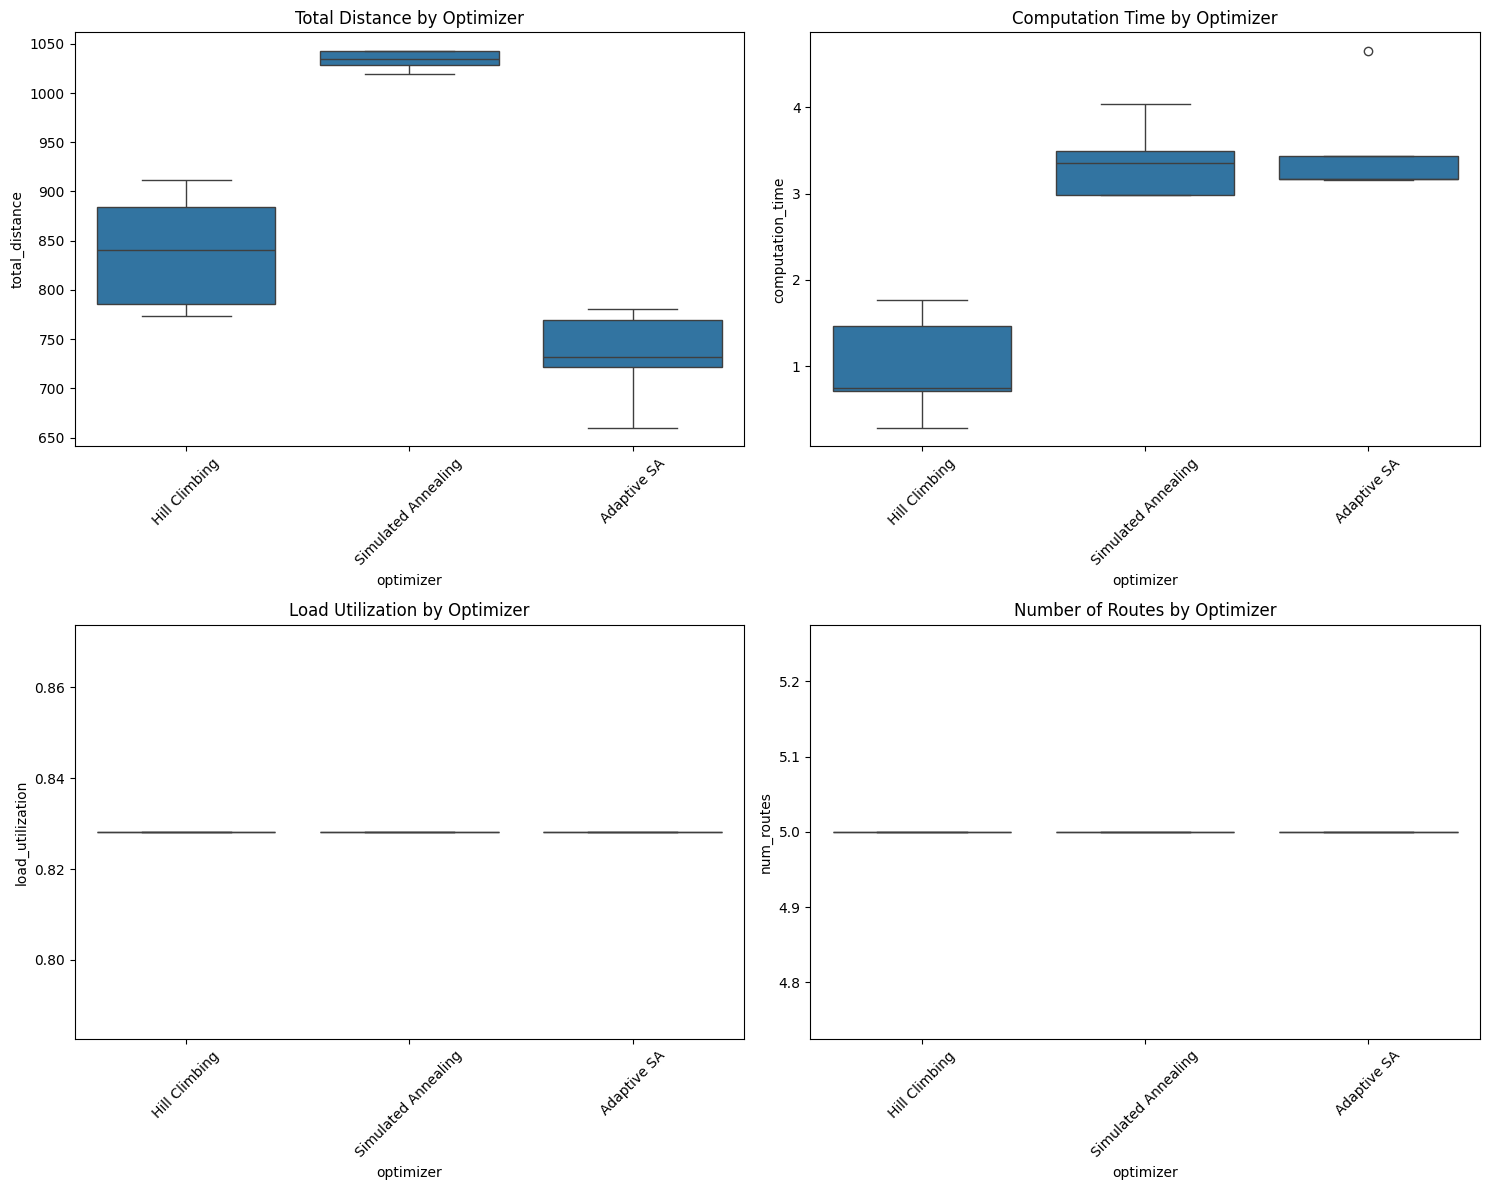

In [ ]:


# Створюємо тестову задачу
problem = generate_test_problem(
    num_warehouses=2,
    num_orders=30,
    num_trucks=5,
    area_size=100,
    seed=300
)

# Створюємо оптимізатори
optimizers = [
    HillClimbingOptimizer(max_iterations=1000),
    SimulatedAnnealingOptimizer(max_iterations=5000),
    AdaptiveSAOptimizer(max_iterations=5000)
]

# Запускаємо порівняння
comparison = OptimizationComparison(problem, optimizers)
results_df = comparison.run_comparison(num_runs=5)

# Виводимо агреговані результати
print("\nАгреговані результати:")
summary = results_df.groupby('optimizer').agg({
    'total_distance': ['mean', 'std'],
    'computation_time': ['mean', 'std'],
    'load_utilization': ['mean', 'std'],
    'num_routes': ['mean', 'std']
}).round(2)
display(summary)

# Візуалізуємо результати
fig = visualize_comparison(results_df)
plt.show()

In [ ]:
results_df

,total_distance,max_route_length,avg_route_length,std_route_length,total_load,load_utilization,num_routes,unassigned_orders,computation_time,num_iterations,optimizer,run
0,773.511568,181.972201,154.702314,30.325529,1564.341238,0.828184,5,0,1.461347,1000,Hill Climbing,1
1,840.073527,234.488677,168.014705,41.320742,1564.341238,0.828184,5,0,1.768348,1000,Hill Climbing,2
2,911.243374,226.030127,182.248675,30.771322,1564.341238,0.828184,5,0,0.289061,1000,Hill Climbing,3
3,883.761803,197.845896,176.752361,15.440739,1564.341238,0.828184,5,0,0.746964,1000,Hill Climbing,4
4,785.437877,197.889048,157.087575,31.973775,1564.341238,0.828184,5,0,0.717795,1000,Hill Climbing,5
5,1042.530355,239.345138,208.506071,21.012749,1564.341238,0.828184,5,0,3.352664,5000,Simulated Annealing,1
6,1035.002203,239.345138,207.000441,21.281452,1564.341238,0.828184,5,0,2.988553,5000,Simulated Annealing,2
7,1019.342534,219.241798,203.868507,13.296182,1564.341238,0.828184,5,0,2.978356,5000,Simulated Annealing,3
8,1042.530355,239.345138,208.506071,21.012749,1564.341238,0.828184,5,0,4.039978,5000,Simulated Annealing,4
9,1028.117674,229.390377,205.623535,18.667671,1564.341238,0.828184,5,0,3.495458,5000,Simulated Annealing,5


## GA

In [ ]:

class ChromosomeEncoder:
    """Клас для кодування/декодування розв'язку в хромосому."""

    @staticmethod
    def encode(solution: Solution) -> List[int]:
        """
        Кодує розв'язок у хромосому.
        Формат: [склад_1, замовлення_1, ..., склад_2, замовлення_1, ...]
        Кожне замовлення кодується своїм ID.
        """
        chromosome = []
        for route in solution.routes:
            # Додаємо склад (зі зсувом для відрізнення від замовлень)
            chromosome.append(1000 + route.warehouse.id)
            # Додаємо замовлення
            for order in route.orders:
                chromosome.append(order.id)
        return chromosome

    @staticmethod
    def decode(chromosome: List[int], problem: LogisticsProblem) -> Solution:
        """Декодує хромосому в розв'язок."""
        solution = Solution(problem)
        current_route = None

        for gene in chromosome:
            if gene >= 1000:  # Це склад
                warehouse_id = gene - 1000
                warehouse = next(w for w in problem.warehouses if w.id == warehouse_id)
                # Шукаємо доступну вантажівку
                available_trucks = [t for t in problem.trucks
                                 if not any(r.truck == t for r in solution.routes)]
                if available_trucks:
                    current_route = Route(
                        truck=available_trucks[0],
                        warehouse=warehouse
                    )
                    solution.add_route(current_route)
            else:  # Це замовлення
                if current_route is not None:
                    order = next(o for o in problem.orders if o.id == gene)
                    if order in solution.unassigned_orders:
                        if current_route.add_order(order):
                            solution.unassigned_orders.remove(order)

        return solution


In [ ]:

class GeneticOperators:
    """Клас з генетичними операторами."""

    @staticmethod
    def crossover(parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
        """
        Реалізує операцію кросовера (OX - Order Crossover).
        """
        if len(parent1) < 2 or len(parent2) < 2:
            return parent1[:], parent2[:]

        # Вибираємо дві точки розрізу
        point1, point2 = sorted(random.sample(range(len(parent1)), 2))

        # Створюємо нащадків
        child1 = [-1] * len(parent1)
        child2 = [-1] * len(parent2)

        # Копіюємо середні частини
        child1[point1:point2] = parent1[point1:point2]
        child2[point1:point2] = parent2[point1:point2]

        # Заповнюємо решту генів
        def fill_remaining(child: List[int], parent: List[int], other_parent: List[int]):
            used_genes = set(g for g in child if g != -1)
            genes_to_add = [g for g in parent + other_parent if g not in used_genes]

            # Використовуємо zip та enumerate для більш ефективного та читабельного коду
            for i, _ in enumerate(child):
                if child[i] == -1:
                    # Перевірка, чи є ще доступні гени для додавання
                    if genes_to_add:
                        child[i] = genes_to_add.pop(0) # Видаляємо використаний ген зі списку
                    else:
                        # Якщо гени закінчилися, заповнюємо значенням за замовчуванням (наприклад, 0)
                        child[i] = 0  # або будь-яке інше значення, яке підходить для вашої задачі

        fill_remaining(child1, parent1, parent2)
        fill_remaining(child2, parent2, parent1)

        return child1, child2

    @staticmethod
    def mutate(chromosome: List[int], mutation_rate: float = 0.1) -> List[int]:
        """
        Реалізує операцію мутації.
        """
        mutated = chromosome[:]

        for i in range(len(mutated)):
            if random.random() < mutation_rate:
                # Якщо це склад, залишаємо його на місці
                if mutated[i] >= 1000:
                    continue

                # Для замовлення - обираємо випадкову позицію для обміну
                j = random.randint(0, len(mutated) - 1)
                if mutated[j] < 1000:  # Міняємо місцями тільки замовлення
                    mutated[i], mutated[j] = mutated[j], mutated[i]

        return mutated



In [ ]:


class GeneticAlgorithm(Optimizer):
    """Реалізація генетичного алгоритму."""

    def __init__(self,
                 population_size: int = 50,
                 num_generations: int = 100,
                 mutation_rate: float = 0.1,
                 elite_size: int = 5):
        """
        Args:
            population_size: розмір популяції
            num_generations: кількість поколінь
            mutation_rate: ймовірність мутації
            elite_size: кількість найкращих особин, що переходять у наступне покоління
        """
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.encoder = ChromosomeEncoder()
        self.operators = GeneticOperators()

    @property
    def name(self) -> str:
        return "Genetic Algorithm"

    def _create_initial_population(self, initial_solution: Solution) -> List[List[int]]:
        """Створює початкову популяцію на основі жадібного розв'язку."""
        population = [self.encoder.encode(initial_solution)]

        while len(population) < self.population_size:
            # Створюємо варіації початкового розв'язку
            chromosome = population[0][:]
            # Виконуємо випадкові перестановки
            for _ in range(random.randint(1, 5)):
                chromosome = self.operators.mutate(chromosome, self.mutation_rate)
            population.append(chromosome)

        return population

    def _evaluate_population(self, population: List[List[int]],
                           problem: LogisticsProblem) -> List[Tuple[List[int], float]]:
        """Оцінює популяцію та сортує за якістю."""
        evaluated = []
        for chromosome in population:
            solution = self.encoder.decode(chromosome, problem)
            fitness = -solution.compute_total_cost()  # негативне, бо мінімізуємо
            evaluated.append((chromosome, fitness))

        return sorted(evaluated, key=lambda x: x[1], reverse=True)

    def _select_parents(self, evaluated_population: List[Tuple[List[int], float]],
                       num_parents: int) -> List[List[int]]:
        """Вибирає батьків за допомогою турнірної селекції."""
        parents = []
        for _ in range(num_parents):
            # Вибираємо випадкових кандидатів для турніру
            tournament = random.sample(evaluated_population,
                                    k=min(3, len(evaluated_population)))
            # Вибираємо найкращого з турніру
            winner = max(tournament, key=lambda x: x[1])
            parents.append(winner[0])
        return parents

    def optimize(self, initial_solution: Solution) -> Tuple[Solution, Dict]:
        """Виконує оптимізацію генетичним алгоритмом."""
        start_time = time()
        problem = initial_solution.problem

        # Створюємо початкову популяцію
        population = self._create_initial_population(initial_solution)
        best_solution = initial_solution
        best_fitness = -initial_solution.compute_total_cost()

        generation = 0
        generations_without_improvement = 0

        while generation < self.num_generations:
            # Оцінюємо популяцію
            evaluated = self._evaluate_population(population, problem)

            # Перевіряємо на покращення
            current_best_fitness = evaluated[0][1]
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_solution = self.encoder.decode(evaluated[0][0], problem)
                generations_without_improvement = 0
                print(f"Generation {generation}: Found better solution. "
                      f"Cost: {-best_fitness:.2f}")
            else:
                generations_without_improvement += 1

            # Відбираємо еліту
            new_population = [chr for chr, _ in evaluated[:self.elite_size]]

            # Створюємо нове покоління
            while len(new_population) < self.population_size:
                # Вибираємо батьків
                parents = self._select_parents(evaluated, 2)

                # Схрещування
                child1, child2 = self.operators.crossover(parents[0], parents[1])

                # Мутація
                child1 = self.operators.mutate(child1, self.mutation_rate)
                child2 = self.operators.mutate(child2, self.mutation_rate)

                new_population.extend([child1, child2])

            # Обмежуємо розмір популяції
            population = new_population[:self.population_size]
            generation += 1

        computation_time = time() - start_time

        metrics = OptimizationMetrics.calculate(best_solution, computation_time,
                                              generation)

        print(f"\nGenetic Algorithm finished after {generation} generations")
        print(f"Initial cost: {initial_solution.compute_total_cost():.2f}")
        print(f"Final cost: {-best_fitness:.2f}")
        print(f"Improvement: {(initial_solution.compute_total_cost() + best_fitness):.2f} "
              f"({(initial_solution.compute_total_cost() + best_fitness) / initial_solution.compute_total_cost() * 100:.1f}%)")

        return best_solution, asdict(metrics)



In [ ]:


# Створюємо тестову задачу
problem = generate_test_problem(
    num_warehouses=2,
    num_orders=50,
    num_trucks=4,
    area_size=100,
    seed=300
)

# Знаходимо початковий розв'язок жадібним алгоритмом
initial_solution = greedy_solution(problem)
print("\nПочатковий розв'язок:")
print(f"Вартість: {initial_solution.compute_total_cost():.2f}")

# Налаштовуємо та запускаємо генетичний алгоритм
ga = GeneticAlgorithm(
    population_size=50,
    num_generations=100,
    mutation_rate=0.1,
    elite_size=5
)

improved_solution, metrics = ga.optimize(initial_solution)

# Оновлюємо список оптимізаторів для порівняння
optimizers = [
    HillClimbingOptimizer(max_iterations=1000),
    SimulatedAnnealingOptimizer(max_iterations=5000),
    AdaptiveSAOptimizer(max_iterations=5000),
    GeneticAlgorithm(num_generations=100)
]

# Запускаємо порівняння
comparison = OptimizationComparison(problem, optimizers)
results_df = comparison.run_comparison(num_runs=3)

# Візуалізуємо результати
fig1 = visualize_solution(initial_solution, "Початковий розв'язок (жадібний)")
fig2 = visualize_solution(improved_solution, "Покращений розв'язок (GA)")
fig3 = visualize_comparison(results_df)
plt.show()



Початковий розв'язок:
Вартість: 801.23
Generation 0: Found better solution. Cost: 0.00

Genetic Algorithm finished after 100 generations
Initial cost: 801.23
Final cost: 0.00
Improvement: 801.23 (100.0%)

Running Hill Climbing...
Run 1/3


ValueError: empty range for randrange() (0, 0, 0)

## Statistic Analisis and Testing Framework


In [ ]:
from pathlib import Path
from scipy import stats
from datetime import datetime
import json

In [ ]:

@dataclass
class ProblemInstance:
    """Клас для опису конкретного екземпляру задачі."""
    name: str
    num_warehouses: int
    num_orders: int
    num_trucks: int
    area_size: float
    seed: int
    description: str

class ProblemGenerator:
    """Генератор різних типів тестових задач."""

    @staticmethod
    def generate_small_instance() -> ProblemInstance:
        """Генерує малу задачу."""
        return ProblemInstance(
            name="small",
            num_warehouses=2,
            num_orders=15,
            num_trucks=3,
            area_size=100,
            seed=42,
            description="Мала задача для швидкого тестування"
        )

    @staticmethod
    def generate_medium_instance() -> ProblemInstance:
        """Генерує середню задачу."""
        return ProblemInstance(
            name="medium",
            num_warehouses=3,
            num_orders=50,
            num_trucks=8,
            area_size=200,
            seed=42,
            description="Середня задача для основного тестування"
        )

    @staticmethod
    def generate_large_instance() -> ProblemInstance:
        """Генерує велику задачу."""
        return ProblemInstance(
            name="large",
            num_warehouses=5,
            num_orders=100,
            num_trucks=15,
            area_size=300,
            seed=42,
            description="Велика задача для стрес-тестування"
        )

    @staticmethod
    def generate_clustered_instance() -> ProblemInstance:
        """Генерує задачу з кластеризованими замовленнями."""
        return ProblemInstance(
            name="clustered",
            num_warehouses=3,
            num_orders=50,
            num_trucks=8,
            area_size=200,
            seed=43,
            description="Задача з кластеризованими замовленнями"
        )


In [ ]:

class StatisticalAnalyzer:
    """Клас для статистичного аналізу результатів."""

    def __init__(self, results_df: pd.DataFrame):
        self.results_df = results_df
        self.significance_level = 0.05

    def perform_anova(self) -> Dict:
        """Виконує однофакторний дисперсійний аналіз."""
        groups = [group for _, group in self.results_df.groupby('optimizer')['total_distance']]
        f_statistic, p_value = stats.f_oneway(*groups)

        return {
            'test_name': 'ANOVA',
            'f_statistic': f_statistic,
            'p_value': p_value,
            'significant': p_value < self.significance_level
        }

    def perform_tukey_hsd(self) -> pd.DataFrame:
        """Виконує попарне порівняння методів (Tukey HSD)."""
        from statsmodels.stats.multicomp import pairwise_tukeyhsd

        tukey = pairwise_tukeyhsd(
            self.results_df['total_distance'],
            self.results_df['optimizer']
        )

        return pd.DataFrame(
            data=tukey._results_table.data[1:],
            columns=['group1', 'group2', 'meandiff', 'p_value', 'lower', 'upper', 'reject']
        )

    def compute_effect_sizes(self) -> pd.DataFrame:
        """Обчислює розміри ефекту (Cohen's d) для пар методів."""
        optimizers = self.results_df['optimizer'].unique()
        effect_sizes = []

        for i in range(len(optimizers)):
            for j in range(i + 1, len(optimizers)):
                opt1, opt2 = optimizers[i], optimizers[j]
                group1 = self.results_df[self.results_df['optimizer'] == opt1]['total_distance']
                group2 = self.results_df[self.results_df['optimizer'] == opt2]['total_distance']

                # Обчислення Cohen's d
                n1, n2 = len(group1), len(group2)
                var1, var2 = group1.var(), group2.var()
                pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
                cohens_d = (group1.mean() - group2.mean()) / pooled_se

                effect_sizes.append({
                    'optimizer1': opt1,
                    'optimizer2': opt2,
                    'cohens_d': cohens_d,
                    'effect_size': 'large' if abs(cohens_d) > 0.8 else
                                 'medium' if abs(cohens_d) > 0.5 else
                                 'small'
                })

        return pd.DataFrame(effect_sizes)


In [ ]:

class TestingFramework:
    """Фреймворк для тестування оптимізаторів на різних задачах."""

    def __init__(self, optimizers: List[Optimizer]):
        self.optimizers = optimizers
        self.results: Dict[str, pd.DataFrame] = {}
        self.statistics: Dict[str, Dict] = {}

    def run_tests(self, num_runs: int = 5):
        """Запускає тести на різних типах задач."""
        problem_instances = [
            ProblemGenerator.generate_small_instance(),
            ProblemGenerator.generate_medium_instance(),
            ProblemGenerator.generate_large_instance(),
            ProblemGenerator.generate_clustered_instance()
        ]

        for instance in problem_instances:
            print(f"\nTesting {instance.name} instance...")
            problem = generate_test_problem(
                num_warehouses=instance.num_warehouses,
                num_orders=instance.num_orders,
                num_trucks=instance.num_trucks,
                area_size=instance.area_size,
                seed=instance.seed
            )

            comparison = OptimizationComparison(problem, self.optimizers)
            results_df = comparison.run_comparison(num_runs)

            # Зберігаємо результати
            self.results[instance.name] = results_df

            # Проводимо статистичний аналіз
            analyzer = StatisticalAnalyzer(results_df)
            self.statistics[instance.name] = {
                'anova': analyzer.perform_anova(),
                'tukey': analyzer.perform_tukey_hsd(),
                'effect_sizes': analyzer.compute_effect_sizes()
            }

    def generate_report(self, output_dir: str = 'results'):
        """Генерує звіт з результатами."""
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Створюємо візуалізації
        for instance_name, results_df in self.results.items():
            fig = self._create_instance_visualizations(
                instance_name, results_df, self.statistics[instance_name]
            )
            fig.savefig(output_path / f'results_{instance_name}_{timestamp}.png')
            plt.close(fig)

        # Зберігаємо статистику
        stats_summary = {}
        for instance_name, stats in self.statistics.items():
            stats_summary[instance_name] = {
                'anova': stats['anova'],
                'tukey': stats['tukey'].to_dict('records'),
                'effect_sizes': stats['effect_sizes'].to_dict('records')
            }

        def convert_to_serializable(obj):
            if isinstance(obj, np.generic):
                return obj.item()
            elif isinstance(obj, pd.DataFrame):
                return obj.to_dict(orient='records')
            elif isinstance(obj, pd.Series):
                return obj.to_list()
            return obj

        with open(output_path / f'statistics_{timestamp}.json', 'w') as f:
            json.dump(stats_summary, f, indent=2, default=convert_to_serializable)

    def _create_instance_visualizations(self, instance_name: str,
                                     results_df: pd.DataFrame,
                                     statistics: Dict) -> plt.Figure:
        """Створює візуалізації для конкретної задачі."""
        fig = plt.figure(figsize=(15, 12))
        gs = plt.GridSpec(3, 2)

        # 1. Boxplot загальної відстані
        ax1 = fig.add_subplot(gs[0, :])
        sns.boxplot(x='optimizer', y='total_distance', data=results_df, ax=ax1)
        ax1.set_title(f'Total Distance Distribution ({instance_name} instance)')
        ax1.tick_params(axis='x', rotation=45)

        # 2. Час обчислень
        ax2 = fig.add_subplot(gs[1, 0])
        sns.boxplot(x='optimizer', y='computation_time', data=results_df, ax=ax2)
        ax2.set_title('Computation Time')
        ax2.tick_params(axis='x', rotation=45)

        # 3. Розміри ефекту
        ax3 = fig.add_subplot(gs[1, 1])
        effect_sizes = statistics['effect_sizes']
        sns.heatmap(
            effect_sizes.pivot(
                index='optimizer1',
                columns='optimizer2',
                values='cohens_d'
            ),
            annot=True,
            cmap='RdYlBu',
            ax=ax3
        )
        ax3.set_title("Effect Sizes (Cohen's d)")

        # 4. Статистична значущість
        ax4 = fig.add_subplot(gs[2, :])
        tukey_results = statistics['tukey']
        significant_pairs = tukey_results[tukey_results['reject']].copy()
        if not significant_pairs.empty:
            significant_pairs['p_value'] = -np.log10(
                significant_pairs['p_value'].astype(float)
            )
            sns.barplot(
                x='group1',
                y='p_value',
                hue='group2',
                data=significant_pairs,
                ax=ax4
            )
            ax4.set_title('Significant Differences (-log10 p-value)')
            ax4.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        return fig



In [ ]:

# Створюємо оптимізатори
optimizers = [
    HillClimbingOptimizer(max_iterations=1000),
    SimulatedAnnealingOptimizer(max_iterations=5000),
    AdaptiveSAOptimizer(max_iterations=5000),
    GeneticAlgorithm(num_generations=100)
]

# Створюємо фреймворк тестування
framework = TestingFramework(optimizers)

# Запускаємо тести
framework.run_tests(num_runs=3)

# Генеруємо звіт
framework.generate_report()

print("\nТестування завершено. Результати збережено в директорії 'results'.")



Testing small instance...

Running Hill Climbing...
Run 1/3
Iteration 1: Found better solution with swap operation. New cost: 574.11
Iteration 6: Found better solution with two_opt operation. New cost: 553.50
Iteration 9: Found better solution with two_opt operation. New cost: 551.73
Iteration 12: Found better solution with two_opt operation. New cost: 526.21
Iteration 13: Found better solution with relocate operation. New cost: 524.73
Iteration 15: Found better solution with relocate operation. New cost: 522.46
Iteration 16: Found better solution with two_opt operation. New cost: 519.67
Iteration 21: Found better solution with swap operation. New cost: 497.00
Iteration 37: Found better solution with relocate operation. New cost: 496.88
Iteration 48: Found better solution with swap operation. New cost: 494.51
Iteration 62: Found better solution with swap operation. New cost: 445.08
Iteration 82: Found better solution with two_opt operation. New cost: 443.60
Iteration 124: Found better

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



Тестування завершено. Результати збережено в директорії 'results'.


In [ ]:
for i, reslult in framework.results.items():
    print(i)

{'small':     total_distance  max_route_length  avg_route_length  std_route_length  \
 0       431.417715        220.612006        143.805905         54.314428   
 1       403.941267        220.612006        134.647089         61.985663   
 2       430.952535        220.612006        143.650845         54.425156   
 3       483.805360        249.300802        161.268453        104.866595   
 4       469.635835        222.457957        156.545278         82.665310   
 5       522.953095        288.455985        174.317698         81.218848   
 6       461.577684        243.971508        153.859228        109.326054   
 7       426.263396        319.564711        142.087799        132.839987   
 8       414.638136        308.286142        138.212712        127.857773   
 9         0.000000          0.000000          0.000000          0.000000   
 10        0.000000          0.000000          0.000000          0.000000   
 11        0.000000          0.000000          0.000000          0.

In [ ]:
framework.statistics

{'small': {'anova': {'test_name': 'ANOVA',
   'f_statistic': 383.9378888716332,
   'p_value': 5.555280728479774e-09,
   'significant': True},
  'tukey':               group1               group2  meandiff  p_value     lower  \
  0        Adaptive SA    Genetic Algorithm -434.1597   0.0000 -486.5801   
  1        Adaptive SA        Hill Climbing  -12.0559   0.8798  -64.4763   
  2        Adaptive SA  Simulated Annealing   57.9717   0.0311    5.5513   
  3  Genetic Algorithm        Hill Climbing  422.1038   0.0000  369.6834   
  4  Genetic Algorithm  Simulated Annealing  492.1314   0.0000  439.7110   
  5      Hill Climbing  Simulated Annealing   70.0276   0.0115   17.6072   
  
        upper  reject  
  0 -381.7393    True  
  1   40.3645   False  
  2  110.3921    True  
  3  474.5242    True  
  4  544.5518    True  
  5  122.4480    True  ,
  'effect_sizes':             optimizer1           optimizer2   cohens_d effect_size
  0        Hill Climbing  Simulated Annealing  -3.115973    

## Hybrid

In [ ]:

class HybridOptimizer(Optimizer):
    """Базовий клас для гібридних оптимізаторів."""

    def __init__(self, name: str):
        self.name = name
        self._optimization_history = []

    @property
    def algorithm_name(self) -> str:
        return self.name

    def record_progress(self, iteration: int, solution: Solution,
                       method: str, cost: float):
        """Записує прогрес оптимізації."""
        self._optimization_history.append({
            'iteration': iteration,
            'method': method,
            'cost': cost
        })



In [ ]:


class MemoryPool:
    """Клас для зберігання та управління найкращими розв'язками."""

    def __init__(self, max_size: int = 10):
        self.max_size = max_size
        self.solutions: List[Tuple[Solution, float]] = []

    def add(self, solution: Solution):
        """Додає новий розв'язок до пулу."""
        cost = solution.compute_total_cost()

        # Перевіряємо, чи розв'язок вже є в пулі
        if not any(abs(existing_cost - cost) < 1e-6
                  for _, existing_cost in self.solutions):
            self.solutions.append((deepcopy(solution), cost))
            # Сортуємо за вартістю (зростання)
            self.solutions.sort(key=lambda x: x[1])
            # Обмежуємо розмір пулу
            if len(self.solutions) > self.max_size:
                self.solutions.pop()

    def get_random(self) -> Optional[Solution]:
        """Повертає випадковий розв'язок з пулу."""
        if not self.solutions:
            return None
        return deepcopy(random.choice(self.solutions)[0])

    def get_best(self) -> Optional[Solution]:
        """Повертає найкращий розв'язок."""
        if not self.solutions:
            return None
        return deepcopy(self.solutions[0][0])



In [ ]:


class GAWithLocalSearch(HybridOptimizer):
    """Гібрид генетичного алгоритму з локальним пошуком."""

    def __init__(self,
                 population_size: int = 50,
                 num_generations: int = 100,
                 local_search_freq: float = 0.1,
                 memory_pool_size: int = 10):
        """
        Args:
            population_size: розмір популяції
            num_generations: кількість поколінь
            local_search_freq: частота застосування локального пошуку
            memory_pool_size: розмір пулу пам'яті
        """
        super().__init__("GA with Local Search")
        self.population_size = population_size
        self.num_generations = num_generations
        self.local_search_freq = local_search_freq
        self.memory_pool = MemoryPool(memory_pool_size)
        self.ga = GeneticAlgorithm(population_size, num_generations)
        self.local_search = HillClimbingOptimizer(max_iterations=100)

    def optimize(self, initial_solution: Solution) -> Tuple[Solution, Dict]:
        """Виконує гібридну оптимізацію."""
        start_time = time()

        # Ініціалізуємо популяцію
        population = self.ga._create_initial_population(initial_solution)
        best_solution = initial_solution
        best_fitness = -initial_solution.compute_total_cost()

        generation = 0
        total_iterations = 0

        while generation < self.num_generations:
            # Генеруємо звіт
    framework.generate_report()

    # Окремо аналізуємо роботу адаптивного гібридного оптимізатора
    adaptive_hybrid = AdaptiveHybridOptimizer()
    solution, metrics = adaptive_hybrid.optimize(initial_solution)

    # Візуалізуємо результати
    fig1 = visualize_solution(initial_solution, "Початковий розв'язок (жадібний)")
    fig2 = visualize_solution(solution, "Покращений розв'язок (Adaptive Hybrid)")
    fig3 = visualize_hybrid_performance(metrics)
    plt.show()

    print("\nРезультати адаптивного гібридного алгоритму:")
    print(f"Початкова вартість: {initial_solution.compute_total_cost():.2f}")
    print(f"Кінцева вартість: {solution.compute_total_cost():.2f}")
    print(f"Покращення: {(initial_solution.compute_total_cost() - solution.compute_total_cost()):.2f} "
          f"({(initial_solution.compute_total_cost() - solution.compute_total_cost()) / initial_solution.compute_total_cost() * 100:.1f}%)")

    print("\nПродуктивність методів:")
    for method, improvement in metrics['method_performance'].items():
        print(f"{method}: {improvement:.2f}")
            evaluated = self.ga._evaluate_population(population,
                                                  initial_solution.problem)

            current_best_chromosome = evaluated[0][0]
            current_solution = self.ga.encoder.decode(
                current_best_chromosome,
                initial_solution.problem
            )
            current_fitness = -current_solution.compute_total_cost()

            # Записуємо прогрес
            self.record_progress(total_iterations, current_solution,
                               "GA", -current_fitness)

            # Перевіряємо на покращення
            if current_fitness > best_fitness:
                best_fitness = current_fitness
                best_solution = deepcopy(current_solution)
                # Додаємо до пулу пам'яті
                self.memory_pool.add(best_solution)
                print(f"Generation {generation}: Found better solution. "
                      f"Cost: {-best_fitness:.2f}")

            # Локальний пошук
            if random.random() < self.local_search_freq:
                # Вибираємо випадковий розв'язок з кращої половини популяції
                candidate_idx = random.randint(0, len(evaluated) // 2)
                candidate = self.ga.encoder.decode(
                    evaluated[candidate_idx][0],
                    initial_solution.problem
                )

                # Застосовуємо локальний пошук
                improved_solution, _ = self.local_search.optimize(candidate)
                improved_fitness = -improved_solution.compute_total_cost()

                self.record_progress(total_iterations, improved_solution,
                                  "Local Search", -improved_fitness)

                if improved_fitness > best_fitness:
                    best_fitness = improved_fitness
                    best_solution = deepcopy(improved_solution)
                    self.memory_pool.add(best_solution)
                    print(f"Local Search improved solution. "
                          f"Cost: {-best_fitness:.2f}")

                # Додаємо покращений розв'язок назад до популяції
                improved_chromosome = self.ga.encoder.encode(improved_solution)
                population = population[:-1] + [improved_chromosome]

            # Створюємо нове покоління
            new_population = [chr for chr, _ in evaluated[:self.ga.elite_size]]

            # Додаємо розв'язок з пулу пам'яті
            if random.random() < 0.1 and self.memory_pool.solutions:
                memory_solution = self.memory_pool.get_random()
                if memory_solution:
                    memory_chromosome = self.ga.encoder.encode(memory_solution)
                    new_population.append(memory_chromosome)

            # Генеруємо решту популяції
            while len(new_population) < self.population_size:
                parents = self.ga._select_parents(evaluated, 2)
                child1, child2 = self.ga.operators.crossover(parents[0], parents[1])
                child1 = self.ga.operators.mutate(child1, self.ga.mutation_rate)
                child2 = self.ga.operators.mutate(child2, self.ga.mutation_rate)
                new_population.extend([child1, child2])

            population = new_population[:self.population_size]
            generation += 1
            total_iterations += 1

        computation_time = time() - start_time
        metrics = OptimizationMetrics.calculate(best_solution, computation_time,
                                              total_iterations)

        return best_solution, asdict(metrics)



In [ ]:


class AdaptiveHybridOptimizer(HybridOptimizer):
    """Адаптивний гібридний оптимізатор."""

    def __init__(self,
                 max_iterations: int = 5000,
                 memory_pool_size: int = 10):
        """
        Args:
            max_iterations: максимальна кількість ітерацій
            memory_pool_size: розмір пулу пам'яті
        """
        super().__init__("Adaptive Hybrid")
        self.max_iterations = max_iterations
        self.memory_pool = MemoryPool(memory_pool_size)

        # Створюємо оптимізатори
        self.ga = GeneticAlgorithm(population_size=30, num_generations=50)
        self.sa = AdaptiveSimulatedAnnealing(max_iterations=1000)
        self.local_search = HillClimbingOptimizer(max_iterations=100)

    def optimize(self, initial_solution: Solution) -> Tuple[Solution, Dict]:
        """Виконує адаптивну гібридну оптимізацію."""
        start_time = time()

        best_solution = initial_solution
        best_cost = initial_solution.compute_total_cost()

        iteration = 0
        stagnation_counter = 0
        method_performance = {
            'GA': 0,
            'SA': 0,
            'Local Search': 0
        }

        while iteration < self.max_iterations:
            # Вибираємо метод на основі їх продуктивності
            if iteration < 100:
                # На початку пробуємо всі методи рівномірно
                method = random.choice(['GA', 'SA', 'Local Search'])
            else:
                # Вибираємо метод зважено на основі їх успішності
                total_improvements = sum(method_performance.values()) + 1e-6
                probabilities = {
                    method: (score + 1e-6) / total_improvements
                    for method, score in method_performance.items()
                }
                method = random.choices(
                    list(probabilities.keys()),
                    weights=list(probabilities.values())
                )[0]

            # Застосовуємо вибраний метод
            if method == 'GA':
                current_solution, _ = self.ga.optimize(best_solution)
            elif method == 'SA':
                current_solution, _ = self.sa.optimize(best_solution)
            else:  # Local Search
                current_solution, _ = self.local_search.optimize(best_solution)

            current_cost = current_solution.compute_total_cost()

            # Записуємо прогрес
            self.record_progress(iteration, current_solution, method, current_cost)

            # Оновлюємо найкращий розв'язок
            if current_cost < best_cost:
                improvement = best_cost - current_cost
                method_performance[method] += improvement
                best_cost = current_cost
                best_solution = deepcopy(current_solution)
                self.memory_pool.add(best_solution)
                stagnation_counter = 0
                print(f"Iteration {iteration}: {method} improved solution. "
                      f"Cost: {best_cost:.2f}")
            else:
                stagnation_counter += 1

            # Диверсифікація при стагнації
            if stagnation_counter >= 100:
                # Спробуємо взяти розв'язок з пулу пам'яті
                memory_solution = self.memory_pool.get_random()
                if memory_solution:
                    best_solution = memory_solution
                    best_cost = best_solution.compute_total_cost()
                    print(f"Iteration {iteration}: Diversifying from memory pool. "
                          f"Cost: {best_cost:.2f}")
                stagnation_counter = 0

            iteration += 1

        computation_time = time() - start_time
        metrics = OptimizationMetrics.calculate(best_solution, computation_time,
                                              iteration)

        # Додаємо інформацію про використання методів
        metrics.update({
            'method_performance': method_performance,
            'optimization_history': self._optimization_history
        })

        return best_solution, metrics



In [ ]:


def visualize_hybrid_performance(metrics: Dict):
    """Візуалізує роботу гібридного алгоритму."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Графік прогресу оптимізації
    history = pd.DataFrame(metrics['optimization_history'])
    for method in history['method'].unique():
        method_data = history[history['method'] == method]
        ax1.scatter(method_data['iteration'], method_data['cost'],
                   label=method, alpha=0.6)

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Solution Cost')
    ax1.set_title('Optimization Progress')
    ax1.legend()
    ax1.grid(True)

    # Графік продуктивності методів
    method_performance = metrics['method_performance']
    ax2.bar(method_performance.keys(), method_performance.values())
    ax2.set_xlabel('Method')
    ax2.set_ylabel('Total Improvement')
    ax2.set_title('Method Performance')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig



In [ ]:


# Створюємо тестову задачу
problem = generate_test_problem(
num_warehouses=2,
num_orders=30,
num_trucks=5,
area_size=100,
seed=42
)

# Знаходимо початковий розв'язок
initial_solution = greedy_solution(problem)
print("\nПочатковий розв'язок:")
print(f"Вартість: {initial_solution.compute_total_cost():.2f}")

# Створюємо та запускаємо гібридні оптимізатори
optimizers = [
    GAWithLocalSearch(),
    AdaptiveHybridOptimizer(),
    GeneticAlgorithm(num_generations=100),
    AdaptiveSAOptimizer(max_iterations=5000)
]

# Запускаємо порівняння
framework = TestingFramework(optimizers)
framework.run_tests(num_runs=3)

# Генеруємо звіт
framework.generate_report()

# Окремо аналізуємо роботу адаптивного гібридного оптимізатора
adaptive_hybrid = AdaptiveHybridOptimizer()
solution, metrics = adaptive_hybrid.optimize(initial_solution)

# Візуалізуємо результати
fig1 = visualize_solution(initial_solution, "Початковий розв'язок (жадібний)")
fig2 = visualize_solution(solution, "Покращений розв'язок (Adaptive Hybrid)")
fig3 = visualize_hybrid_performance(metrics)
plt.show()

print("\nРезультати адаптивного гібридного алгоритму:")
print(f"Початкова вартість: {initial_solution.compute_total_cost():.2f}")
print(f"Кінцева вартість: {solution.compute_total_cost():.2f}")
print(f"Покращення: {(initial_solution.compute_total_cost() - solution.compute_total_cost()):.2f} "
    f"({(initial_solution.compute_total_cost() - solution.compute_total_cost()) / initial_solution.compute_total_cost() * 100:.1f}%)")

print("\nПродуктивність методів:")
for method, improvement in metrics['method_performance'].items():
    print(f"{method}: {improvement:.2f}")